## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於進一步調整 Vin Iout vs I in I out 兩種不同物理量輸入模型之差異 (也比較好解釋) ###
### 模型採用 經典的CNN 模型 但使用 wide input 與 multiscale brach 來更好的抓取訊號 ###
### 2025 0826 基於0825版本 但使用Agent 進行調整###



### 導入模型設定與套件 ###

In [3]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical devices cannot be modified after being initialized


### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

In [4]:
# =============================================================================
# 導入必要的模組
# =============================================================================
from datetime import datetime
import json
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, AdditiveAttention

# =============================================================================
# 模型參數設定
# =============================================================================
# 基本參數
sequence_length = 1024
layer_number = 1
future_length = 512

# 模型儲存設定
model_folder_path = r'NTU_rul_models\CCAE_models'
model_name = f'0827_singlescale_CCAE_Base{sequence_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

# CNN 模型參數
WD_length = 64
WD_stride = 4
branch_kernels = (3,)
enc_depth = 3
encoder_decay_rate = 0.5
base_filters = 32

# =============================================================================
# 多分支 CNN 自編碼器模型定義
# =============================================================================
def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True,
    # 第一層（分支前）設定
    first_kernel_size=64,
    first_layer_filters=None,
    first_stride=1,
    # 分支 kernels（每個分支全程沿用自己的 k）
    first_branch_kernels=(3, 5, 7),
    # 既有參數
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None,
    # 反捲積（還原第一層 stride）kernel，預設沿用 first_kernel_size
    deconv_kernel_size=None,
    # ★ 是否學殘差：output_i = pred_i + input_i
    learn_residual=False,
):
    """
    多分支 CNN 自編碼器
    
    特色功能：
    - Stem conv: 若 iscondition=True，使用 FiLM (Feature-wise Linear Modulation)
                 condition 會輸出 γ(scale)、β(shift) 來調控 filter 輸出。
    - 若 iscondition=False，直接使用 stem conv 輸出。
    - Encoder（多分支）：各分支全程用自己的 k；每層 MaxPool(2)
    - Decoder（多分支）：UpSampling(2)+Conv1D(k, stride=1)
    - Merge 後：1x1 Conv 融合（此處也套用第二次 FiLM，再 ReLU）
    - 還原第一層 stride：Conv1DTranspose(depthwise, stride=first_stride)
    - learn_residual：若為 True，對每個輸出做 pred_i + input_i（學習Δ）
    """
    import tensorflow as tf
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, Dense, UpSampling1D,
        MaxPooling1D, Reshape, Multiply, Add, Activation
    )
    from tensorflow.keras.models import Model

    try:
        from tensorflow.keras.layers import Conv1DTranspose
    except Exception as e:
        raise ImportError(
            "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
        ) from e

    # === filters 配置 ===
    if filters_per_block is not None:
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    if first_layer_filters is None:
        first_layer_filters = base_filters
    if deconv_kernel_size is None:
        deconv_kernel_size = first_kernel_size

    # === 序列輸入（逐個輸入保留，方便殘差直連） ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
    # concat 版（供幹道卷積使用）
    series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === 條件輸入 ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === Stem Conv (FiLM #1) ===
    stem_conv = Conv1D(
        filters=first_layer_filters,
        kernel_size=first_kernel_size,
        strides=first_stride,
        padding='same',
        activation=None,
        name=f'stem_conv_k{first_kernel_size}_s{first_stride}'
    )(series_input)

    if iscondition:
        gamma1 = Dense(first_layer_filters, name='stem_gamma')(merged_condition)
        beta1  = Dense(first_layer_filters, name='stem_beta')(merged_condition)
        gamma1 = Reshape((1, first_layer_filters))(gamma1)
        beta1  = Reshape((1, first_layer_filters))(beta1)
        stem = Add(name='stem_film')([
            Multiply()([stem_conv, gamma1]), beta1
        ])
    else:
        stem = stem_conv

    stem = Activation('relu', name='stem_relu')(stem)

    # === Encoder / Decoder branches ===
    def cnn_branch(x, k, name_prefix):
        z = x
        for b in range(blocks):
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_enc_c{b+1}_k{k}_s1'
            )(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)

        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
            )(z)
        return z

    branch_outputs = [cnn_branch(stem, k, name_prefix=f'branch_k{k}') for k in first_branch_kernels]
    merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)

    # === 1x1 融合不同 branch（FiLM #2 位置） ===
    fuse_width = max(f_list[0], first_layer_filters, base_filters)
    fused_linear = Conv1D(  # 先不激活，讓 FiLM 調制後再 ReLU
        fuse_width, 1, padding='same', activation=None, name='fusion_conv1x1'
    )(merged)

    if iscondition:
        gamma2 = Dense(fuse_width, name='fusion_gamma')(merged_condition)
        beta2  = Dense(fuse_width, name='fusion_beta')(merged_condition)
        gamma2 = Reshape((1, fuse_width))(gamma2)
        beta2  = Reshape((1, fuse_width))(beta2)
        fused = Add(name='fusion_film')([
            Multiply()([fused_linear, gamma2]), beta2
        ])
    else:
        fused = fused_linear

    fused = Activation('relu', name='fusion_relu')(fused)

    # === 還原第一層 stride（depthwise transpose）===
    if first_stride > 1:
        fused = Conv1DTranspose(
            filters=2,  # depthwise 風格，僅為還原時間長度；後續每通道再 Dense 輸出
            kernel_size=deconv_kernel_size,
            strides=first_stride,
            padding='same',
            activation='linear',
            name=f'undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
        )(fused)

    # === Output per input channel-group（每個輸出各自 Dense 到對應通道數） ===
    preds = [Dense(dim, activation='linear', name=f'pred_{idx}')(fused)
             for idx, dim in enumerate(input_dim_list)]

    # === 若學殘差：output_i = pred_i + input_i ===
    if learn_residual:
        outputs = []
        for idx, (pred_i, inp_i) in enumerate(zip(preds, inputs)):
            # 形狀保證：(sequence_length, dim)
            # 若 MaxPool/UpSampling 造成長度不對齊，這裡會報錯，提示使用者調整 sequence_length 或 blocks
            try:
                out_i = Add(name=f'output_residual_{idx}')([pred_i, inp_i])
            except Exception as e:
                raise ValueError(
                    f"[Residual Add] 維度不相容：pred_{idx} 與 series_{idx}。"
                    " 請確認 sequence_length 可被 2**blocks 整除，並避免因 Pool/UpSampling 造成長度漂移。"
                ) from e
            outputs.append(out_i)
    else:
        outputs = [tf.identity(p, name=f'output_{idx}') for idx, p in enumerate(preds)]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=outputs,
        name="CNN_MultiBranch_AE_FiLM"
    )
    return model

# =============================================================================
# 模型配置與建立
# =============================================================================

def create_model_and_metadata(model_config, model_suffix):
    """建立模型和對應的 metadata"""
    model = build_cnn_multi_branch_ae(**model_config)
    
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "trained": False,
        "train_date": None,
    }
    
    with open(os.path.join(model_path, model_name + model_suffix + '_metadata.json'), "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    
    return model

# 基本配置
base_config = {
    'input_dim_list': [2],
    'sequence_length': sequence_length,
    'condition_dim': 1,
    'first_kernel_size': WD_length,
    'first_stride': WD_stride,
    'first_branch_kernels': branch_kernels,
    'base_filters': base_filters,
    'blocks': enc_depth,
    'decay': encoder_decay_rate,
}

# 模型配置清單
model_configs = [
    # VI model 陽春版 無condition 與殘差
    {**base_config, 'iscondition': False, 'learn_residual': False},
    # VI 加入殘差
    {**base_config, 'iscondition': False, 'learn_residual': True},
    # VI 加入殘差與condition
    {**base_config, 'iscondition': True, 'learn_residual': True},
    # I to I model
    {**base_config, 'iscondition': False, 'learn_residual': False},
]

model_suffixes = ['_VI', '_VI_res', '_VI_res_cond', '_II']

# 建立所有模型
models = {}
for config, suffix in zip(model_configs, model_suffixes):
    models[suffix] = create_model_and_metadata(config, suffix)

# 解構模型變數（保持向後相容）
my_model_V_in_I_out = models['_VI']
my_model_V_in_I_out_res = models['_VI_res']
my_model_V_in_I_out_res_cond = models['_VI_res_cond']
my_model_I_in_I_out = models['_II']

my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_VI_test.keras'))
my_model_V_in_I_out = load_model(os.path.join(model_path, model_name + '_VI_test.keras'))
# =============================================================================
# 模型視覺化和輸出
# =============================================================================

# 儲存模型圖
for suffix, model in models.items():
    plot_model(
        model, 
        to_file=os.path.join(model_path, model_name + suffix + '.png'), 
        show_shapes=True, 
        show_layer_names=True
    )

# 輸出模型資訊
print("All Model saved and loaded successfully.")
for suffix, model in models.items():
    print(f"{model_name}{suffix} parameters: {model.count_params():,}")

ValueError: A `Concatenate` layer should be called on a list of at least 1 input. Received: input_shape=(None, 256, 32)

### 訓練資料前處理 ###

In [3]:
# =============================================================================
# 數據增強函數定義
# =============================================================================
import shutil
from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt

def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    """
    從原始資料中隨機選取樣本進行數據增強
    """
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length = sequence_length + future_length  
    
    # 從原始資料df中隨機選取augmen_sample_number個起始點為sequence_length長度的序列樣本。
    # raw_data為n,4的序列資料，每一行分別為voltage alpha, voltage beta, current alpha, current beta
    
    # 資料增強倍率
    max_augment_factor = len(raw_data) - sequence_length + 1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)

    # 隨機選取augmen_sample_number個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成NumPy多維陣列
    final_data = np.array(samples_list)
    
    return final_data

# =============================================================================
# 電機參數設定
# =============================================================================
Fs = 20000  # 採樣頻率
Rs = 12.5   # 定子電阻
P = 4       # 極對數

# =============================================================================
# 數據集路徑設定
# =============================================================================
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets3_1'
normal_condition = 'Normal1'
normal_condition2 = 'Normal1-2'
Normal_data_path = os.path.join(NTU_dataset_path, normal_condition)
Normal_data_path2 = os.path.join(NTU_dataset_path, normal_condition2)

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]
# 重複訓練資料夾
Normal_subfolders2 = [f.path for f in os.scandir(Normal_data_path2) if f.is_dir()]
print(Normal_subfolders2)
# 選擇特定的工況資料夾
selected_folder=[
    f"{normal_condition} 1200 1.0v 2kg cm2",
    f"{normal_condition} 1200 0.5v 2kg cm2",
    f"{normal_condition} 1200 2.0v 2kg cm2",
    f"{normal_condition} 1800 0.5v 2kg cm2",
    f"{normal_condition} 1800 2.0v 2kg cm2",
    f"{normal_condition} 1800 1.0v 2kg cm2",
    f"{normal_condition} 3000 1.0v 2kg cm2",
    f"{normal_condition} 3000 2.0v 2kg cm2",
    f"{normal_condition} 3000 0.5v 2kg cm2"
]
# 選擇與selected_folder名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]
for folder in Normal_subfolders:
    print(folder)
    
selected_folder2=[
    f"{normal_condition2} 1200 1.0v 2kg cm2",
    f"{normal_condition2} 1200 0.5v 2kg cm2",
    f"{normal_condition2} 1200 2.0v 2kg cm2",
    f"{normal_condition2} 1800 0.5v 2kg cm2",
    f"{normal_condition2} 1800 2.0v 2kg cm2",
    f"{normal_condition2} 1800 1.0v 2kg cm2",
    f"{normal_condition2} 3000 1.0v 2kg cm2",
    f"{normal_condition2} 3000 2.0v 2kg cm2",
    f"{normal_condition2} 3000 0.5v 2kg cm2"
]
Normal_subfolders2=[folder for folder in Normal_subfolders2 if any(sel in folder for sel in selected_folder2)]
for folder in Normal_subfolders2:
    print(folder)


# =============================================================================
# 訓練/驗證資料分割功能
# =============================================================================
# 建立驗證資料夾
if not os.path.exists(os.path.join(NTU_dataset_path, "validation")):
    os.makedirs(os.path.join(NTU_dataset_path, "validation"))
validation_folder_path = os.path.join(NTU_dataset_path, "validation")

def split_train_val_files(Normal_subfolders, test_size=0.2):
    """分割訓練和驗證檔案"""
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個parquet檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

def copy_val_files_to_validation(val_files, validation_folder_path):
    for file_path in val_files:
        # 取得原始檔案所在的資料夾名稱
        class_name = os.path.basename(os.path.dirname(file_path))
        # 在validation資料夾下建立對應子資料夾
        class_folder = os.path.join(validation_folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        # 複製檔案到對應子資料夾
        shutil.copy(file_path, class_folder)

train_files1, val_files = split_train_val_files(Normal_subfolders, test_size=0.2)
train_files2, _ = split_train_val_files(Normal_subfolders2, test_size=0.2)
train_files=train_files1
# train_files = train_files1 + train_files2
# =============================================================================
# 數據讀取和處理
# =============================================================================
# 主要使用的變數
train_signals = []  # vi signals alpha beta 
train_signals_normalized = []
torque_array = []
speed_array_pu = []

# ❌ 未使用的變數（後續程式碼中未引用）
flux_signals = []  # emf flux signals alpha beta - 未使用
current_diff_array = []  # 未使用

for file_path in train_files:
    if os.path.exists(file_path):
        
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=False)
        
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1:
            # 檢測極性校正是否失效
            print(f"File {file_path} has high THD, skipping.")
            continue
            
        current_alpha = np.array(df["Current alpha downsample"])
        current_beta = np.array(df["Current beta downsample"])
        flux_alpha = np.array(df["Flux alpha"])
        flux_beta = np.array(df["Flux beta"])
        
        emf_alpha = (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta = (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        
        torque_airgap = 1.5 * 4 * (flux_alpha * current_beta - flux_beta * current_alpha)  # 計算torque
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.mean(torque_airgap)
          
        torque = (df["Torque avg"]) 
        speed = (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [
            np.array(df["Voltage alpha downsample"]), 
            np.array(df["Voltage beta downsample"]),
            current_alpha,
            current_beta,
            flux_alpha,
            flux_beta,
            emf_alpha,
            emf_beta,
            torque_airgap
        ]
        
        temp_train_signals_normalized = []
        # 將數據標準化（均值為0，標準差為1）
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
                
        temp_train_signals_normalized[-1] = torque_airgap_normalized  # 改成std正規化的torque_airgap
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        
        augmen_sample_number = 500  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number, future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number, future_length=future_length)
        
        # 加入train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed / 3000)  # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")

# =============================================================================
# 數據後處理和分割
# =============================================================================        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前sequence_length個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後future_length個

# 正規化訓練資料
train_signals_normalized = train_signals_normalized[indices]
train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
train_fit_signals_normalized = train_signals_normalized[:, -future_length:, :]

# 運轉條件資料
torque_array = torque_array[indices]
speed_array_pu = speed_array_pu[indices]
torque_array = torque_array.reshape(-1, 1)      # 將torque_array轉為n, 1 batch輸入狀態標籤
speed_array_pu = speed_array_pu.reshape(-1, 1)

# ========================================================================
# 🟢 實際使用的變數（訓練所需資料）
# =============================================================================
# 模型參考輸入
past_voltages = train_input_signals[:, :, 0:2]
past_currents = train_input_signals[:, :, 2:4]
past_fluxes = train_input_signals[:, :, 4:6]  # 使用過去的flux作為輸入
past_emf = train_input_signals[:, :, 6:8]  # 使用過去的emf作為輸入
past_airgap_torque = train_input_signals[:, :, 8:9]  # 使用過去的torque作為輸入

# 正規化資料
past_voltages_normalized = train_input_signals_normalized[:, :, 0:2]
past_currents_normalized = train_input_signals_normalized[:, :, 2:4]
past_fluxes_normalized = train_input_signals_normalized[:, :, 4:6]
past_emf_normalized = train_input_signals_normalized[:, :, 6:8]  # 使用過去的emf作為輸入
past_airgap_torque_normalized = train_input_signals_normalized[:, :, 8:9]  # 使用過去的torque作為輸入  

# 模型參考輸出
future_voltages = train_fit_signals[:, :, 0:2]
future_currents = train_fit_signals[:, :, 2:4]
future_fluxes = train_fit_signals[:, :, 4:6]
future_emf = train_fit_signals[:, :, 6:8]  # 使用過去的emf作為輸入
future_airgap_torque = train_fit_signals[:, :, 8:9]  # 使用未來的torque作為輸出

# 正規化資料
future_voltages_normalized = train_fit_signals_normalized[:, :, 0:2]
future_currents_normalized = train_fit_signals_normalized[:, :, 2:4]
future_fluxes_normalized = train_fit_signals_normalized[:, :, 4:6]
future_emf_normalized = train_fit_signals_normalized[:, :, 6:8]  # 使用過去的emf作為輸入
future_airgap_torque_normalized = train_fit_signals_normalized[:, :, 8:9]  # 使用未來的torque作為輸出

# =============================================================================
# ❌ 未使用的變數（可考慮移除）
# =============================================================================
# 完整時間長度資料，後續會進行分割
time_sequence_all = np.arange(0, sequence_length + future_length, 1)  # shape: (time_length,)
time_sequence_all = time_sequence_all[None, :, None] / Fs  # shape: (1, time_length, 1)
theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi  # broadcasting達成(batch_size, time_length, 1)

# 延伸訓練所需資料（對比不同物理量訓練效果使用，未來可能用到）
# past_theta = theta_all_rad[:, :sequence_length, :]  # 取前sequence_length個時間步長
# future_theta = theta_all_rad[:, sequence_length:, :]  # 取最後future_length個時間
# past_theta_cos_sin = np.concatenate([np.cos(past_theta), np.sin(past_theta)], axis=-1)  # 將theta轉為sin/cos
# future_theta_cos_sin = np.concatenate([np.cos(future_theta), np.sin(future_theta)], axis=-1)  # 將theta轉為sin/cos

# speed_current = train_input_signals[:, :, 2:4] * speed_array_pu[:, None, :]  # ❌ 未使用

# =============================================================================
# 數據形狀檢查
# =============================================================================
print("=== 主要使用的數據形狀 ===")
print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
print(f"torque_array shape: {torque_array.shape}")
print(f"speed_array_pu shape: {speed_array_pu.shape}")

print("\n=== 實際訓練使用的變數 ===")
print(f"past_voltages shape: {past_voltages.shape}")
print(f"past_currents shape: {past_currents.shape}")
print(f"past_emf shape: {past_emf.shape}")
print(f"past_fluxes shape: {past_fluxes.shape}")

print("\n=== ❌ 未使用的變數（可考慮移除）===")
# print(f"speed_current shape: {speed_current.shape} - 未使用")
# print(f"time_sequence_all shape: {time_sequence_all.shape} - 未使用")
# print(f"theta_all shape: {theta_all_rad.shape} - 未使用")
# print(f"past_theta shape: {past_theta.shape} - 未使用")

['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 1200 0.5v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 1200 1.0v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 1200 2.0v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 1800 0.5v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 1800 1.0v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 1800 2.0v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 3000 0.5v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 3000 1.0v 2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1-2 3000 2.0v 2kg cm2']
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal1\Normal1 1200 0.5v 2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal1\Normal1 1200 1.0v 2kg cm2
D:\OneDrive

=== 主要使用的數據形狀 ===
train_input_signals shape: (56500, 1024, 9)
train_fit_signals shape: (56500, 512, 9)
torque_array shape: (56500, 1)
speed_array_pu shape: (56500, 1)

=== 實際訓練使用的變數 ===
past_voltages shape: (56500, 1024, 2)
past_currents shape: (56500, 1024, 2)
past_emf shape: (56500, 1024, 2)
past_fluxes shape: (56500, 1024, 2)

=== ❌ 未使用的變數（可考慮移除）===


(56500, 1024, 1)


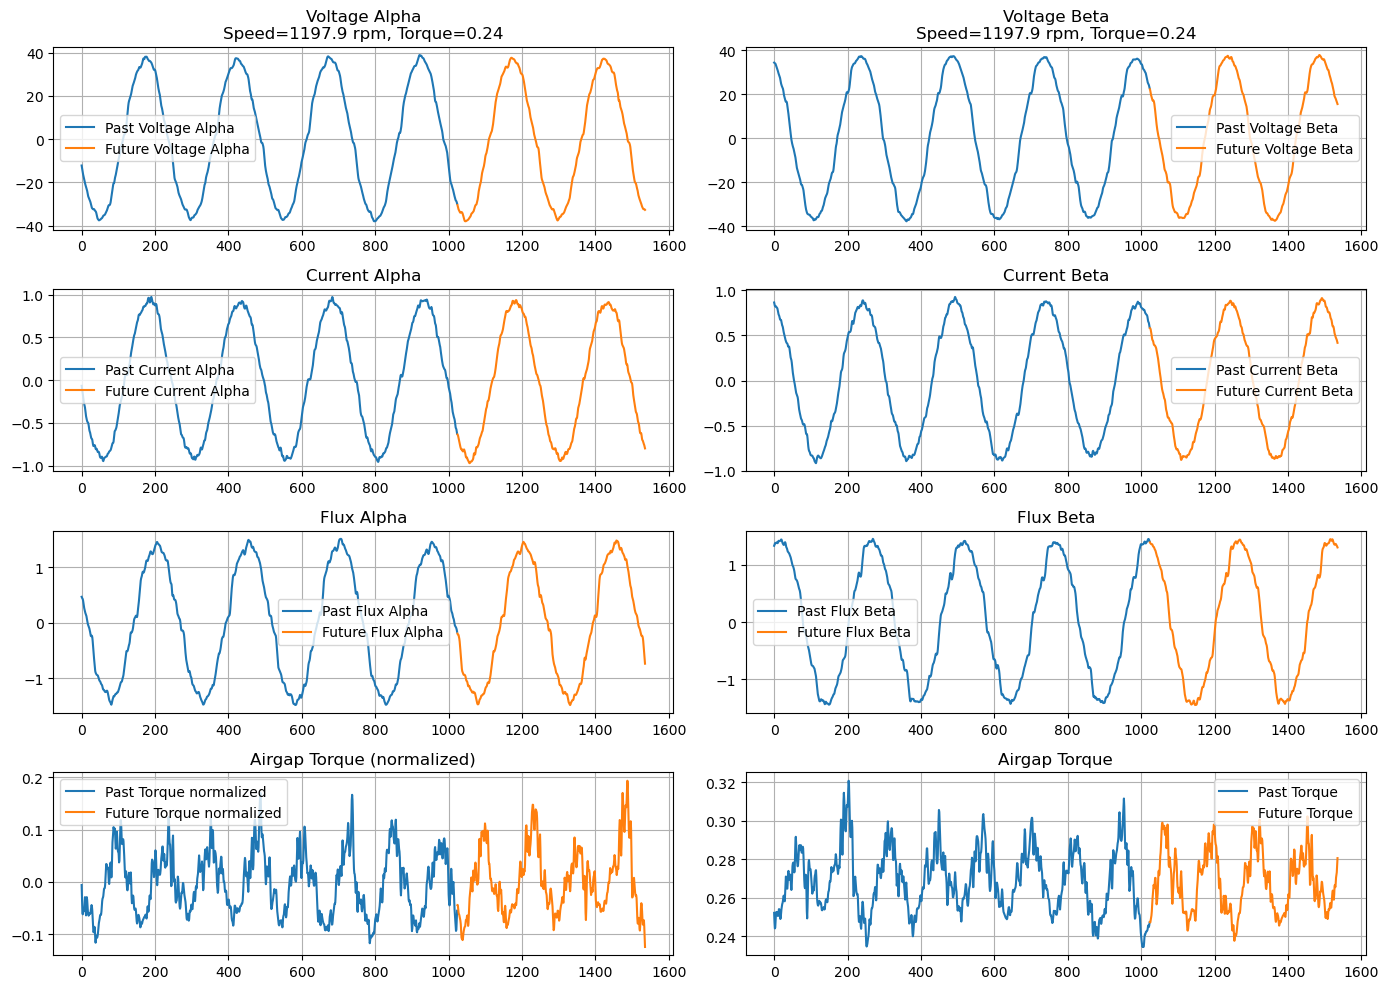

In [4]:
idx = 1  # 可調整索引以觀察不同樣本

def plot_raw_data(idx):
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    time_past = np.arange(sequence_length)
    time_future = np.arange(sequence_length, sequence_length + future_length)

    # 取得運轉條件
    speed_val = speed_array_pu[idx, 0] * 3000  # 還原為 rpm
    torque_val = torque_array[idx, 0]

    # 電壓
    axs[0, 0].plot(time_past, past_voltages[idx, :, 0], label='Past Voltage Alpha')
    axs[0, 0].plot(time_future, future_voltages[idx, :, 0], label='Future Voltage Alpha')
    axs[0, 0].set_title(f'Voltage Alpha\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    axs[0, 1].plot(time_past, past_voltages[idx, :, 1], label='Past Voltage Beta')
    axs[0, 1].plot(time_future, future_voltages[idx, :, 1], label='Future Voltage Beta')
    axs[0, 1].set_title(f'Voltage Beta\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 電流
    axs[1, 0].plot(time_past, past_currents[idx, :, 0], label='Past Current Alpha')
    axs[1, 0].plot(time_future, future_currents[idx, :, 0], label='Future Current Alpha')
    axs[1, 0].set_title('Current Alpha')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(time_past, past_currents[idx, :, 1], label='Past Current Beta')
    axs[1, 1].plot(time_future, future_currents[idx, :, 1], label='Future Current Beta')
    axs[1, 1].set_title('Current Beta')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 磁通
    axs[2, 0].plot(time_past, past_emf_normalized[idx, :, 0], label='Past Flux Alpha')
    axs[2, 0].plot(time_future, future_emf_normalized[idx, :, 0], label='Future Flux Alpha')
    axs[2, 0].set_title('Flux Alpha')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    axs[2, 1].plot(time_past, past_emf_normalized[idx, :, 1], label='Past Flux Beta')
    axs[2, 1].plot(time_future, future_emf_normalized[idx, :, 1], label='Future Flux Beta')
    axs[2, 1].set_title('Flux Beta')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # 力矩
    print(past_airgap_torque_normalized.shape)
    axs[3, 0].plot(time_past, past_airgap_torque_normalized[idx, :,0], label='Past Torque normalized')
    axs[3, 0].plot(time_future, future_airgap_torque_normalized[idx, :,0], label='Future Torque normalized')
    axs[3, 0].set_title('Airgap Torque (normalized)')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    axs[3, 1].plot(time_past, past_airgap_torque[idx, : ,0], label='Past Torque')
    axs[3, 1].plot(time_future, future_airgap_torque[idx, :,0], label='Future Torque')
    axs[3, 1].set_title('Airgap Torque')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    plt.tight_layout()
    plt.show()
plot_raw_data(idx)

### 訊練模型 ###

Vin Iout

模型訓練配置:
- 使用權重訓練: False
- 使用GPU: True
- 批次大小: 128
- 訓練週期: 50
- 驗證比例: 0.1

開始訓練模型: 0827_singlescale_CCAE_Base1024_VI
測試模型結構...
測試預測輸出形狀: (1, 1024, 2)
模型結構驗證通過，開始訓練...

⚖️ 使用均勻權重訓練
使用設備: /GPU:0

🚀 開始訓練 - 批次大小: 128, 週期: 50
Epoch 1/50
398/398 [==============================] - 9s 17ms/step - loss: 0.0714 - val_loss: 0.0107 - lr: 0.0010
Epoch 2/50
398/398 [==============================] - 7s 17ms/step - loss: 0.0086 - val_loss: 0.0073 - lr: 0.0010
Epoch 3/50
398/398 [==============================] - 6s 15ms/step - loss: 0.0068 - val_loss: 0.0060 - lr: 0.0010
Epoch 4/50
398/398 [==============================] - 6s 16ms/step - loss: 0.0058 - val_loss: 0.0053 - lr: 0.0010
Epoch 5/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0052 - val_loss: 0.0050 - lr: 0.0010
Epoch 6/50
398/398 [==============================] - 6s 15ms/step - loss: 0.0048 - val_loss: 0.0047 - lr: 0.0010
Epoch 7/50
398/398 [==============================] - 6s 16ms/step - loss: 0.0045 - val_loss: 0.

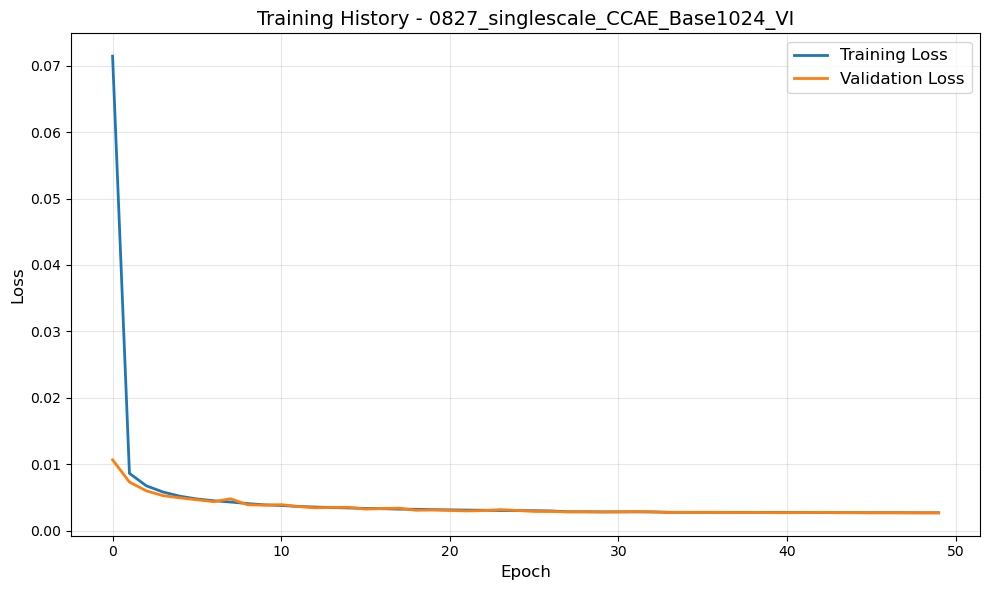

✅ 模型已儲存: NTU_rul_models\CCAE_models\0827_singlescale_CCAE_Base1024\0827_singlescale_CCAE_Base1024_VI.keras
✅ 訓練元數據已儲存: NTU_rul_models\CCAE_models\0827_singlescale_CCAE_Base1024\0827_singlescale_CCAE_Base1024_VI_metadata.json

🎉 VI 模型訓練完成!
最終訓練損失: 0.002712
最終驗證損失: 0.002699
最佳驗證損失: 0.002698


In [5]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")

# 執行訓練
history_VI = train_model(
    model=my_model_V_in_I_out,
    model_suffix='_VI',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_currents_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VI = save_training_results(my_model_V_in_I_out, history_VI, '_VI')

print(f"\n🎉 VI 模型訓練完成!")
print(f"最終訓練損失: {metadata_VI['final_train_loss']:.6f}")
if metadata_VI['final_val_loss']:
    print(f"最終驗證損失: {metadata_VI['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VI['best_val_loss']:.6f}")

In [9]:
# =============================================================================
# 數據集建立和管理
# =============================================================================

def list_subfolders(path):
    """列出指定路徑下的所有子資料夾"""
    if not os.path.exists(path):
        print(f"⚠️ 路徑不存在: {path}")
        return []
    return [f.path for f in os.scandir(path) if f.is_dir()]

# 載入訓練好的模型
# my_model_V_in_I_out = load_model(os.path.join(model_path, model_name + '_VI.keras'))
print("✅ 模型載入成功")

def get_apply_files_data(folder_path, return_val=False, test_size=0, augmen_sample_number=20):
    """
    取得指定工況資料夾下的所有檔案資料
    
    Parameters:
    - folder_path: 資料夾路徑
    - return_val: 是否返回驗證資料
    - test_size: 驗證資料比例
    - augmen_sample_number: 資料增強樣本數量
    """
    if not os.path.exists(folder_path):
        print(f"⚠️ 資料夾不存在: {folder_path}")
        return {}, {}
    
    parquet_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".parquet")]
    
    if len(parquet_files) == 0:
        print(f"⚠️ 資料夾內無 parquet 檔案: {folder_path}")
        return {}, {}
    
    # 分割訓練和驗證檔案
    if len(parquet_files) > 1 and test_size > 0:
        apply_parquet_files, apply_val_files = train_test_split(parquet_files, test_size=test_size, random_state=42)
    else:
        apply_parquet_files = parquet_files
        apply_val_files = []
    
    def process_files(file_list, sample_number):
        """處理檔案列表"""
        train_signals = []
        train_signals_normalized = []
        torque_array = []
        speed_array_pu = []
        
        for file_path in file_list:
            if not os.path.exists(file_path):
                print(f"File {file_path} does not exist.")
                continue
                
            # 讀取資料
            df = read_rul_data(file_path, force_recompute=False)
            if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
                print(f"File {file_path} has high THD, skipping.")
                continue
                
            current_alpha = np.array(df["Current alpha downsample"])
            current_beta = np.array(df["Current beta downsample"])
            flux_alpha = np.array(df["Flux alpha"])
            flux_beta = np.array(df["Flux beta"])
            
            if flux_alpha.shape[0] != current_alpha.shape[0]:
                print(f"File {file_path} has mismatched flux and current lengths, skipping.")
                continue
                
            torque_airgap = 1.5 * 4 * (flux_alpha * current_beta - flux_beta * current_alpha)
            emf_alpha = (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)
            emf_beta = (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
            
            # 標準化
            torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
            torque = df["Torque avg"]
            speed = df["Speed"][0]
            
            # 合併信號資料
            temp_train_signals = [
                np.array(df["Voltage alpha downsample"]), 
                np.array(df["Voltage beta downsample"]),
                current_alpha,
                current_beta,
                flux_alpha,
                flux_beta,
                emf_alpha,
                emf_beta,
                torque_airgap
            ]
            
            # 標準化處理
            temp_train_signals_normalized = []
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
            
            temp_train_signals_normalized[-1] = torque_airgap_normalized
            
            try:
                temp_train_signals = np.stack(temp_train_signals, axis=1)
                temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            except ValueError as e:
                print(f"Error stacking signals for file {file_path}: {e}")
                continue
                
            # 資料增強
            temp_train_input_signals_augmented = data_random_augmentation(
                temp_train_signals, sequence_length, 
                augmen_sample_number=sample_number, future_length=future_length
            )
            temp_train_signals_normalized_augmented = data_random_augmentation(
                temp_train_signals_normalized, sequence_length, 
                augmen_sample_number=sample_number, future_length=future_length
            )
            
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(sample_number) * torque)
            speed_array_pu.append(np.ones(sample_number) * speed / 3000)
        
        if len(train_signals) == 0:
            return {
                "input_signals": np.array([]),
                "input_signals_normalized": np.array([]),
                "fit_signals": np.array([]),
                "fit_signals_normalized": np.array([]),
                "torque_array": np.array([]),
                "speed_array_pu": np.array([])
            }
        
        train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
        train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
        torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
        speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
        
        return {
            "input_signals": train_signals[:, :sequence_length, :],
            "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],
            "fit_signals": train_signals[:, -future_length:, :],
            "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],
            "torque_array": torque_array.reshape(-1, 1),
            "speed_array_pu": speed_array_pu.reshape(-1, 1)
        }
    
    # 處理主要檔案
    apply_data = process_files(apply_parquet_files, augmen_sample_number)
    
    # 處理驗證檔案
    apply_data_val = {}
    if return_val and len(apply_val_files) > 0:
        apply_data_val = process_files(apply_val_files, 50)  # 驗證用較少樣本
    
    return apply_data, apply_data_val

# =============================================================================
# 工況定義
# =============================================================================
# 運轉條件定義
CONDITIONS = ["1200 0.5v", "1200 1.0v", "1200 2.0v",
              "1800 0.5v", "1800 1.0v", "1800 2.0v",
              "3000 0.5v", "3000 1.0v", "3000 2.0v"]

# 所有工況資料夾定義
CONDITION_FOLDERS = {
    # 正常工況
    'Normal1': 'Normal1',
    'Normal1-2': 'Normal1-2', 
    'Normal2': 'Normal2',
    'Normal2-2': 'Normal2-2',
    
    # 鑽孔故障
    'drill_2mm_q1mm': 'drill 2mm q=1mm',
    'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
    
    # 磨損故障  
    'wear_out_1': 'wear out 1',
    'wear_out_1_2': 'wear out 1-2',
    'wear_out_2_worse': 'wear out 2(worse)',
    'wear_out_2_worse_2': 'wear out 2(worse)-2',
    
    # 驗證資料
    'validation': 'validation'
}

# =============================================================================
# 建立所有工況的數據集
# =============================================================================
print("🚀 開始建立所有工況的數據集...")
print(f"基礎路徑: {NTU_dataset_path}")
print("="*60)

# 儲存所有數據集的字典
all_datasets = {}
all_validation_datasets = {}

for condition_key, folder_name in CONDITION_FOLDERS.items():
    print(f"\n📁 處理工況: {condition_key} -> {folder_name}")
    
    condition_path = os.path.join(NTU_dataset_path, folder_name)
    
    if not os.path.exists(condition_path):
        print(f"⚠️ 跳過 - 資料夾不存在: {condition_path}")
        continue
    
    # 取得子資料夾
    subfolders = list_subfolders(condition_path)
    
    if len(subfolders) == 0:
        print(f"⚠️ 跳過 - 無子資料夾: {condition_path}")
        continue
    
    print(f"   發現 {len(subfolders)} 個子資料夾")
    
    # 建立此工況的數據集字典
    condition_datasets = {}
    condition_validation_datasets = {}
    
    for folder in subfolders:
        folder_name_short = os.path.basename(folder)
        # print(f"   處理子資料夾: {folder_name_short}")
        
        try:
            # 根據是否為正常工況決定是否分割驗證資料
            if 'Normal' in condition_key:
                dataset, val_dataset = get_apply_files_data(folder, return_val=True, test_size=0.2, augmen_sample_number=50)
                condition_validation_datasets[folder] = val_dataset
            else:
                dataset, _ = get_apply_files_data(folder, return_val=False, augmen_sample_number=50)
            
            condition_datasets[folder] = dataset
            
            # 顯示數據集統計
            if not len(dataset.get('input_signals', [])) > 0:
                print(f"      ⚠️ 無有效資料")
                
        except Exception as e:
            print(f"      ❌ 錯誤: {str(e)}")
    
    # 儲存到總字典
    all_datasets[condition_key] = condition_datasets
    if condition_validation_datasets:
        all_validation_datasets[condition_key] = condition_validation_datasets
    
    print(f"   🏁 {condition_key} 完成 - 共 {len(condition_datasets)} 個有效子資料夾")

# =============================================================================
# 數據集摘要
# =============================================================================
print("\n" + "="*60)
print("📊 數據集建立摘要")
print("="*60)

total_datasets = 0
total_samples = 0

for condition_key, condition_datasets in all_datasets.items():
    condition_samples = 0
    valid_folders = 0
    
    for folder_path, dataset in condition_datasets.items():
        if len(dataset.get('input_signals', [])) > 0:
            folder_samples = dataset['input_signals'].shape[0]
            condition_samples += folder_samples
            valid_folders += 1
    
    if valid_folders > 0:
        print(f"{condition_key:20} | {valid_folders:2d} 個資料夾 | {condition_samples:5d} 樣本")
        total_datasets += valid_folders
        total_samples += condition_samples
    else:
        print(f"{condition_key:20} | ❌ 無有效資料")

print("-" * 60)
print(f"{'總計':20} | {total_datasets:2d} 個資料夾 | {total_samples:5d} 樣本")

# =============================================================================
# 向後相容性 - 保持原有變數名稱
# =============================================================================
print("\n🔄 設定向後相容性變數...")

# 原有的變數名稱對應
if 'Normal1' in all_datasets:
    normal_datasets = all_datasets['Normal1']
    validation_datasets = all_validation_datasets.get('Normal1', {})

if 'Normal1-2' in all_datasets:
    normal2_datasets = all_datasets['Normal1-2']

if 'wear_out_1' in all_datasets:
    abnormal_datasets = all_datasets['wear_out_1']

if 'wear_out_2_worse' in all_datasets:
    abnormal2_datasets = all_datasets['wear_out_2_worse']

if 'drill_2mm_q1mm' in all_datasets:
    abnormal3_datasets = all_datasets['drill_2mm_q1mm']

print("✅ 所有數據集建立完成！")
print(f"✅ 可用工況: {list(all_datasets.keys())}")

✅ 模型載入成功
🚀 開始建立所有工況的數據集...
基礎路徑: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1

📁 處理工況: Normal1 -> Normal1
   發現 9 個子資料夾
   🏁 Normal1 完成 - 共 9 個有效子資料夾

📁 處理工況: Normal1-2 -> Normal1-2
   發現 9 個子資料夾
   🏁 Normal1-2 完成 - 共 9 個有效子資料夾

📁 處理工況: Normal2 -> Normal2
   發現 9 個子資料夾
⚠️ 資料夾內無 parquet 檔案: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2\Normal2 1200 2.0v 2kg cm
      ⚠️ 無有效資料
   🏁 Normal2 完成 - 共 9 個有效子資料夾

📁 處理工況: Normal2-2 -> Normal2-2
   發現 9 個子資料夾
   🏁 Normal2-2 完成 - 共 9 個有效子資料夾

📁 處理工況: drill_2mm_q1mm -> drill 2mm q=1mm
   發現 9 個子資料夾
   🏁 drill_2mm_q1mm 完成 - 共 9 個有效子資料夾

📁 處理工況: drill_2mm_q1mm_2 -> drill 2mm q=1mm-2
   發現 9 個子資料夾
   🏁 drill_2mm_q1mm_2 完成 - 共 9 個有效子資料夾

📁 處理工況: wear_out_1 -> wear out 1
   發現 9 個子資料夾
   🏁 wear_out_1 完成 - 共 9 個有效子資料夾

📁 處理工況: wear_out_1_2 -> wear out 1-2
   發現 9 個子資料夾
   🏁 wear_out_1_2 完成 - 共 9 個有效子資料夾

📁 處理工況: wear_out_2_worse -> wear out 2(worse)
   發現 9 個子資料夾
   🏁 wear_out_2_worse 完成 - 共 9 個有效子資料夾

📁 處理工況: wear_out_2_worse_2 -> wear out 2(wo

In [7]:
os.path.join(model_path, model_name + '_VI.keras')

'NTU_rul_models\\CCAE_models\\0827_singlescale_CCAE_Base1024\\0827_singlescale_CCAE_Base1024_VI.keras'

計算各工況的重建MSE...
可用工況: ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm

開始按運轉條件繪圖...
使用 'Normal1' 作為基準正常工況


C:\Users\MotorTech\AppData\Local\Temp\ipykernel_33128\686624680.py:418: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_test, y_test,


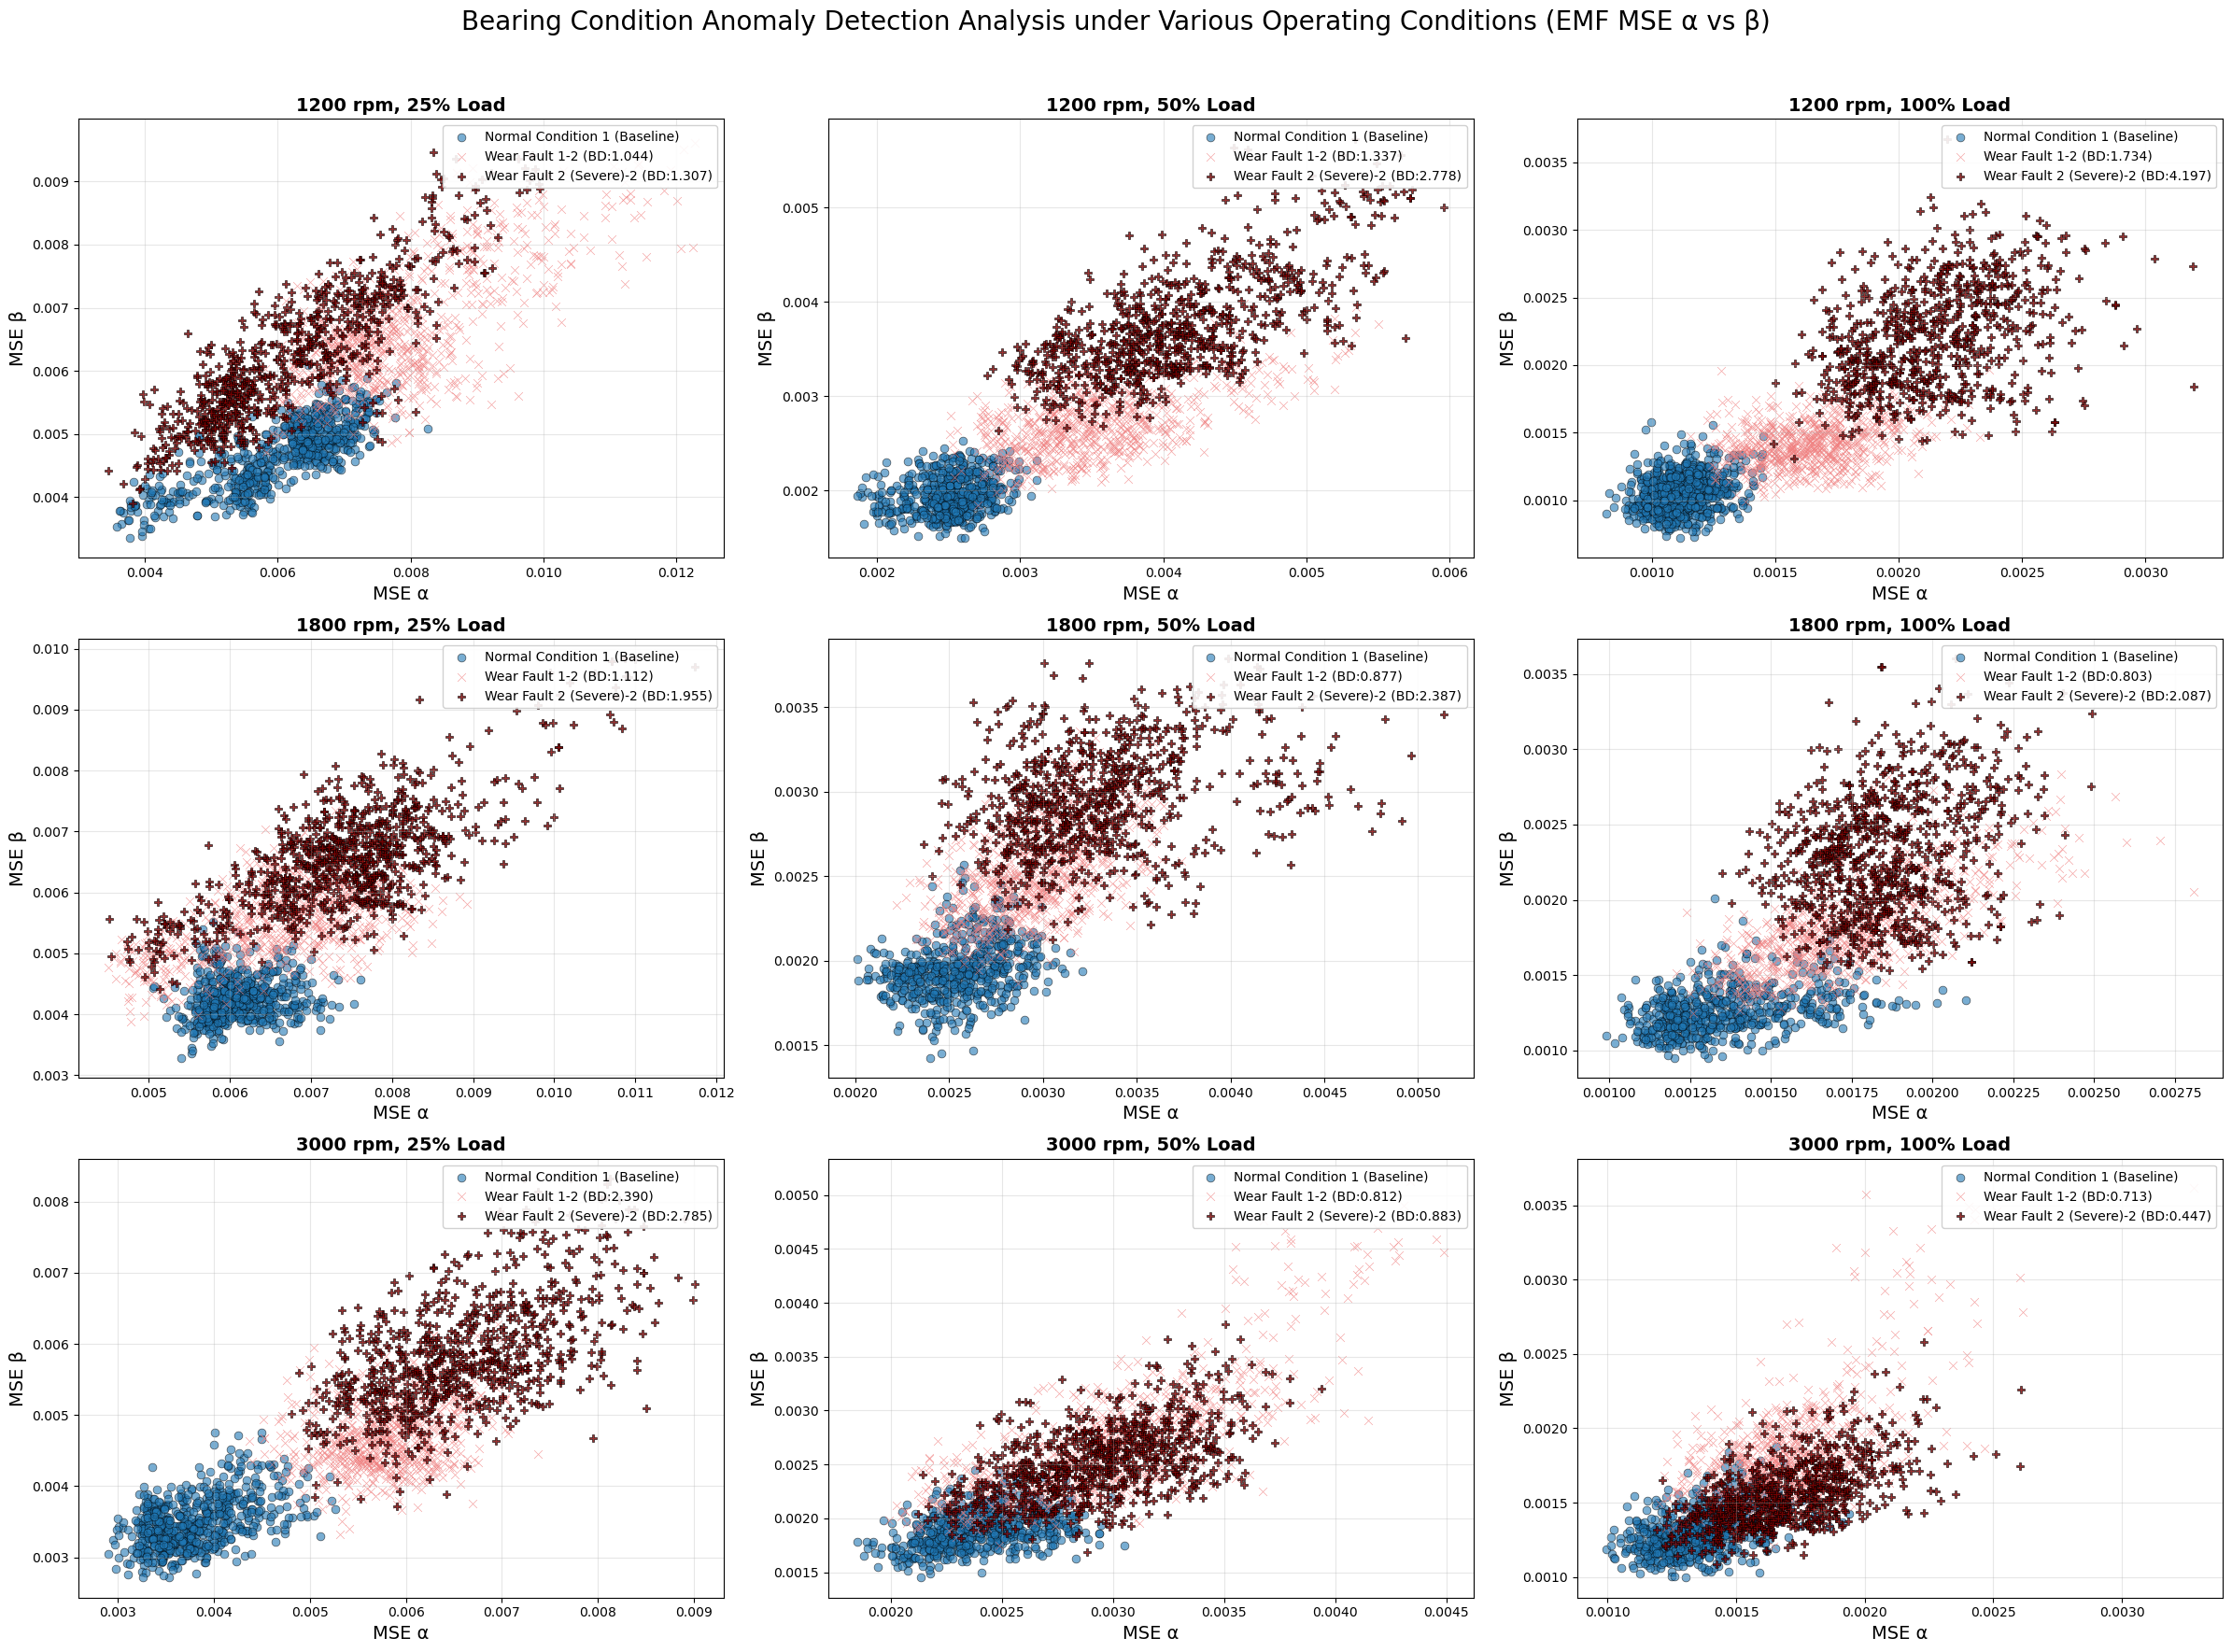


Anomaly Detection Results Summary for Each Operating Condition
(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)

🔧 1200 rpm, 25% Load
------------------------------------------------------------
   ❌ Normal Condition 1-2 | BD Distance: 0.9647 | Anomaly Rate: 0.833 (25/30)
   ❌ Normal Condition 2   | BD Distance: 0.1428 | Anomaly Rate: 0.143 (5/35)
   ❌ Normal Condition 2-2 | BD Distance: 0.1536 | Anomaly Rate: 0.100 (3/30)
   ❌ Drill Fault 2mm      | BD Distance: 1.2947 | Anomaly Rate: 0.979 (47/48)
   ❌ Drill Fault 2mm-2    | BD Distance: 2.4173 | Anomaly Rate: 1.000 (38/38)
   ❌ Wear Fault 1         | BD Distance: 0.2848 | Anomaly Rate: 0.083 (4/48)
   ✅ Wear Fault 1-2       | BD Distance: 1.0442 | Anomaly Rate: 1.000 (40/40)
   ❌ Wear Fault 2 (Severe) | BD Distance: 1.6510 | Anomaly Rate: 1.000 (38/38)
   ✅ Wear Fault 2 (Severe)-2 | BD Distance: 1.3065 | Anomaly Rate: 1.000 (38/38)

🔧 1200 rpm, 50% Load
------------------------------------------------------

In [10]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """判斷樣本是否來自指定高斯分布（使用卡方檢定）"""
    samples = np.array(samples)
    mean = np.array(mean)
    cov = np.array(cov)
    
    # 計算馬氏距離平方
    inv_cov = np.linalg.inv(cov)
    diff = samples - mean
    m_dist2 = np.sum(diff @ inv_cov * diff, axis=1)
    
    # 卡方檢定
    test_stat = np.mean(m_dist2)
    p_value = 1 - chi2.cdf(test_stat, df=2)
    is_from_gaussian = p_value > alpha
    
    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

### 3. 電流 in 電流 out ###
訓練

準備電流訓練資料...
電流輸入形狀: (56500, 1024, 2)
電流輸出形狀: (56500, 1024, 2)

開始訓練模型: _II
使用加權訓練: False
  使用標準訓練（無加權）
Epoch 1/50
398/398 [==============================] - 9s 17ms/step - loss: 0.0038 - val_loss: 0.0024 - lr: 0.0010
Epoch 2/50
398/398 [==============================] - 6s 16ms/step - loss: 0.0024 - val_loss: 0.0024 - lr: 0.0010
Epoch 3/50
398/398 [==============================] - 7s 17ms/step - loss: 0.0023 - val_loss: 0.0022 - lr: 0.0010
Epoch 4/50
398/398 [==============================] - 7s 17ms/step - loss: 0.0022 - val_loss: 0.0023 - lr: 0.0010
Epoch 5/50
398/398 [==============================] - 8s 21ms/step - loss: 0.0022 - val_loss: 0.0021 - lr: 0.0010
Epoch 6/50
398/398 [==============================] - 7s 17ms/step - loss: 0.0022 - val_loss: 0.0020 - lr: 0.0010
Epoch 7/50
398/398 [==============================] - 6s 16ms/step - loss: 0.0021 - val_loss: 0.0021 - lr: 0.0010
Epoch 8/50
398/398 [==============================] - 7s 17ms/step - loss: 0.0021 - val_loss: 0.002

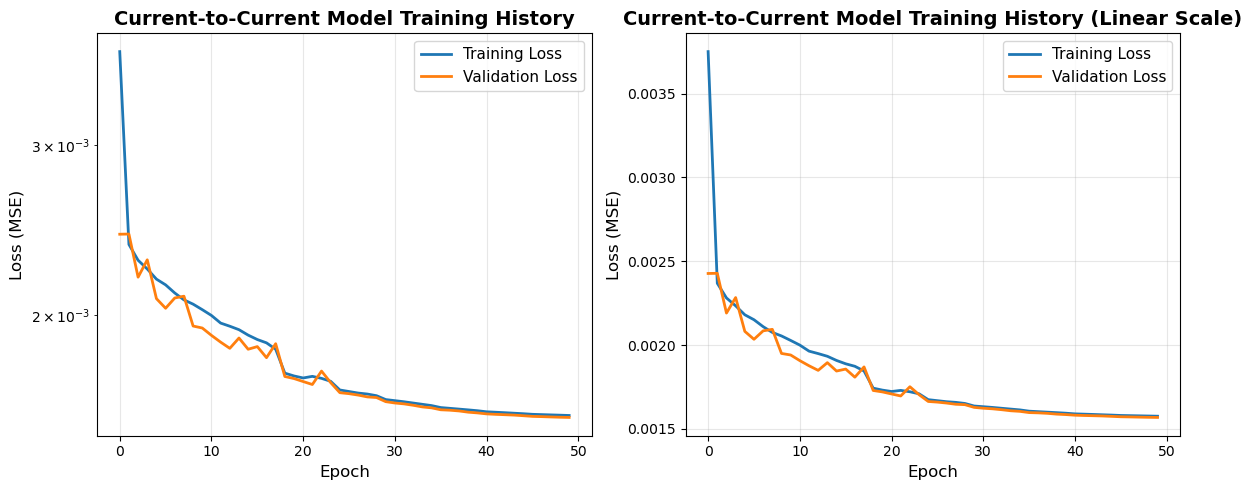


🎯 my_model_I_in_I_out 訓練完成摘要
✅ 模型類型: 電流輸入 -> 電流輸出 (自編碼器)
📊 訓練樣本數: 56,500
🔢 序列長度: 1024
⚡ 訓練輪數: 50
📉 最終訓練 Loss: 0.001576
📈 最終驗證 Loss: 0.001568
⚖️ 使用加權訓練: 否
🔧 模型參數數量: 47,192
💾 模型檔案: 0826_multiscale_CCAE_Base1024_II.keras

✅ my_model_I_in_I_out 建立並訓練完成！


In [ ]:


# 訓練函數（與 my_model_V_in_I_out 相同的配置）
def train_model_II(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練 I_in_I_out 模型的函數
    """
    print(f"\n開始訓練模型: {model_suffix}")
    print(f"使用加權訓練: {use_weighted}")
    
    # 準備輸入資料
    input_signals = x_data  # 電流輸入 [current_alpha, current_beta]
    output_signals = y_data  # 電流輸出 [current_alpha, current_beta]
    
    # 編譯模型
    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
        loss='mse'
    )
    
    # 學習率調度器
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    # 早停機制
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    
    # 準備加權
    if use_weighted:
        print("  使用加權訓練（基於扭矩和速度）")
        # 計算樣本權重（與 V_in_I_out 模型相同的邏輯）
        t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
        spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
        combined_weight = t_weight * spd_weight
        combined_weight = np.clip(combined_weight, 0.1, 5.0)  # 限制權重範圍
        
        # 開始訓練
        history = model.fit(
            x=[input_signals, speed_array_pu, torque_array],
            y=output_signals,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            sample_weight=combined_weight,
            callbacks=[lr_scheduler, early_stop],
            verbose=1
        )
    else:
        print("  使用標準訓練（無加權）")
        # 開始訓練
        history = model.fit(
            x=[input_signals, speed_array_pu, torque_array],
            y=output_signals,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[lr_scheduler, early_stop],
            verbose=1
        )
    
    return history

# 準備電流訓練資料
print("準備電流訓練資料...")
print(f"電流輸入形狀: {past_currents_normalized.shape}")
print(f"電流輸出形狀: {past_currents_normalized.shape}")

# 執行訓練
history_II = train_model_II(
    model=my_model_I_in_I_out,
    model_suffix='_II',
    x_data=past_currents_normalized,  # 輸入：正規化的電流訊號
    y_data=past_currents_normalized,  # 輸出：重建的電流訊號（自編碼器）
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存訓練結果函數
def save_training_results_II(model, history, model_suffix):
    """儲存訓練結果和模型"""
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存至: {model_save_path}")
    
    # 更新 metadata
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "train_loss": float(history.history['loss'][-1]),
        "val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "epochs_trained": len(history.history['loss']),
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "model_type": "Current_input_Current_output"
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    
    print(f"✅ 訓練記錄已儲存至: {metadata_path}")
    return metadata

# 儲存訓練結果
metadata_II = save_training_results_II(my_model_I_in_I_out, history_II, '_II')

# 繪製訓練曲線
print("\n📊 繪製訓練曲線...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_II.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history_II.history:
    plt.plot(history_II.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Current-to-Current Model Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(history_II.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history_II.history:
    plt.plot(history_II.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Current-to-Current Model Training History (Linear Scale)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 訓練結果摘要
print("\n" + "="*70)
print("🎯 my_model_I_in_I_out 訓練完成摘要")
print("="*70)
print(f"✅ 模型類型: 電流輸入 -> 電流輸出 (自編碼器)")
print(f"📊 訓練樣本數: {past_currents_normalized.shape[0]:,}")
print(f"🔢 序列長度: {sequence_length}")
print(f"⚡ 訓練輪數: {len(history_II.history['loss'])}")
print(f"📉 最終訓練 Loss: {history_II.history['loss'][-1]:.6f}")
if 'val_loss' in history_II.history:
    print(f"📈 最終驗證 Loss: {history_II.history['val_loss'][-1]:.6f}")
print(f"⚖️ 使用加權訓練: {'是' if USE_WEIGHTED_TRAINING else '否'}")
print(f"🔧 模型參數數量: {my_model_I_in_I_out.count_params():,}")
print(f"💾 模型檔案: {model_name}_II.keras")
print("="*70)

print(f"\n✅ my_model_I_in_I_out 建立並訓練完成！")

結果展示

計算各工況的重建MSE...
可用工況: ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm

開始按運轉條件繪圖...
使用 'Normal1' 作為基準正常工況

開始按運轉條件繪圖...
使用 'Normal1' 作為基準正常工況


C:\Users\MotorTech\AppData\Local\Temp\ipykernel_15700\698787186.py:418: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_test, y_test,


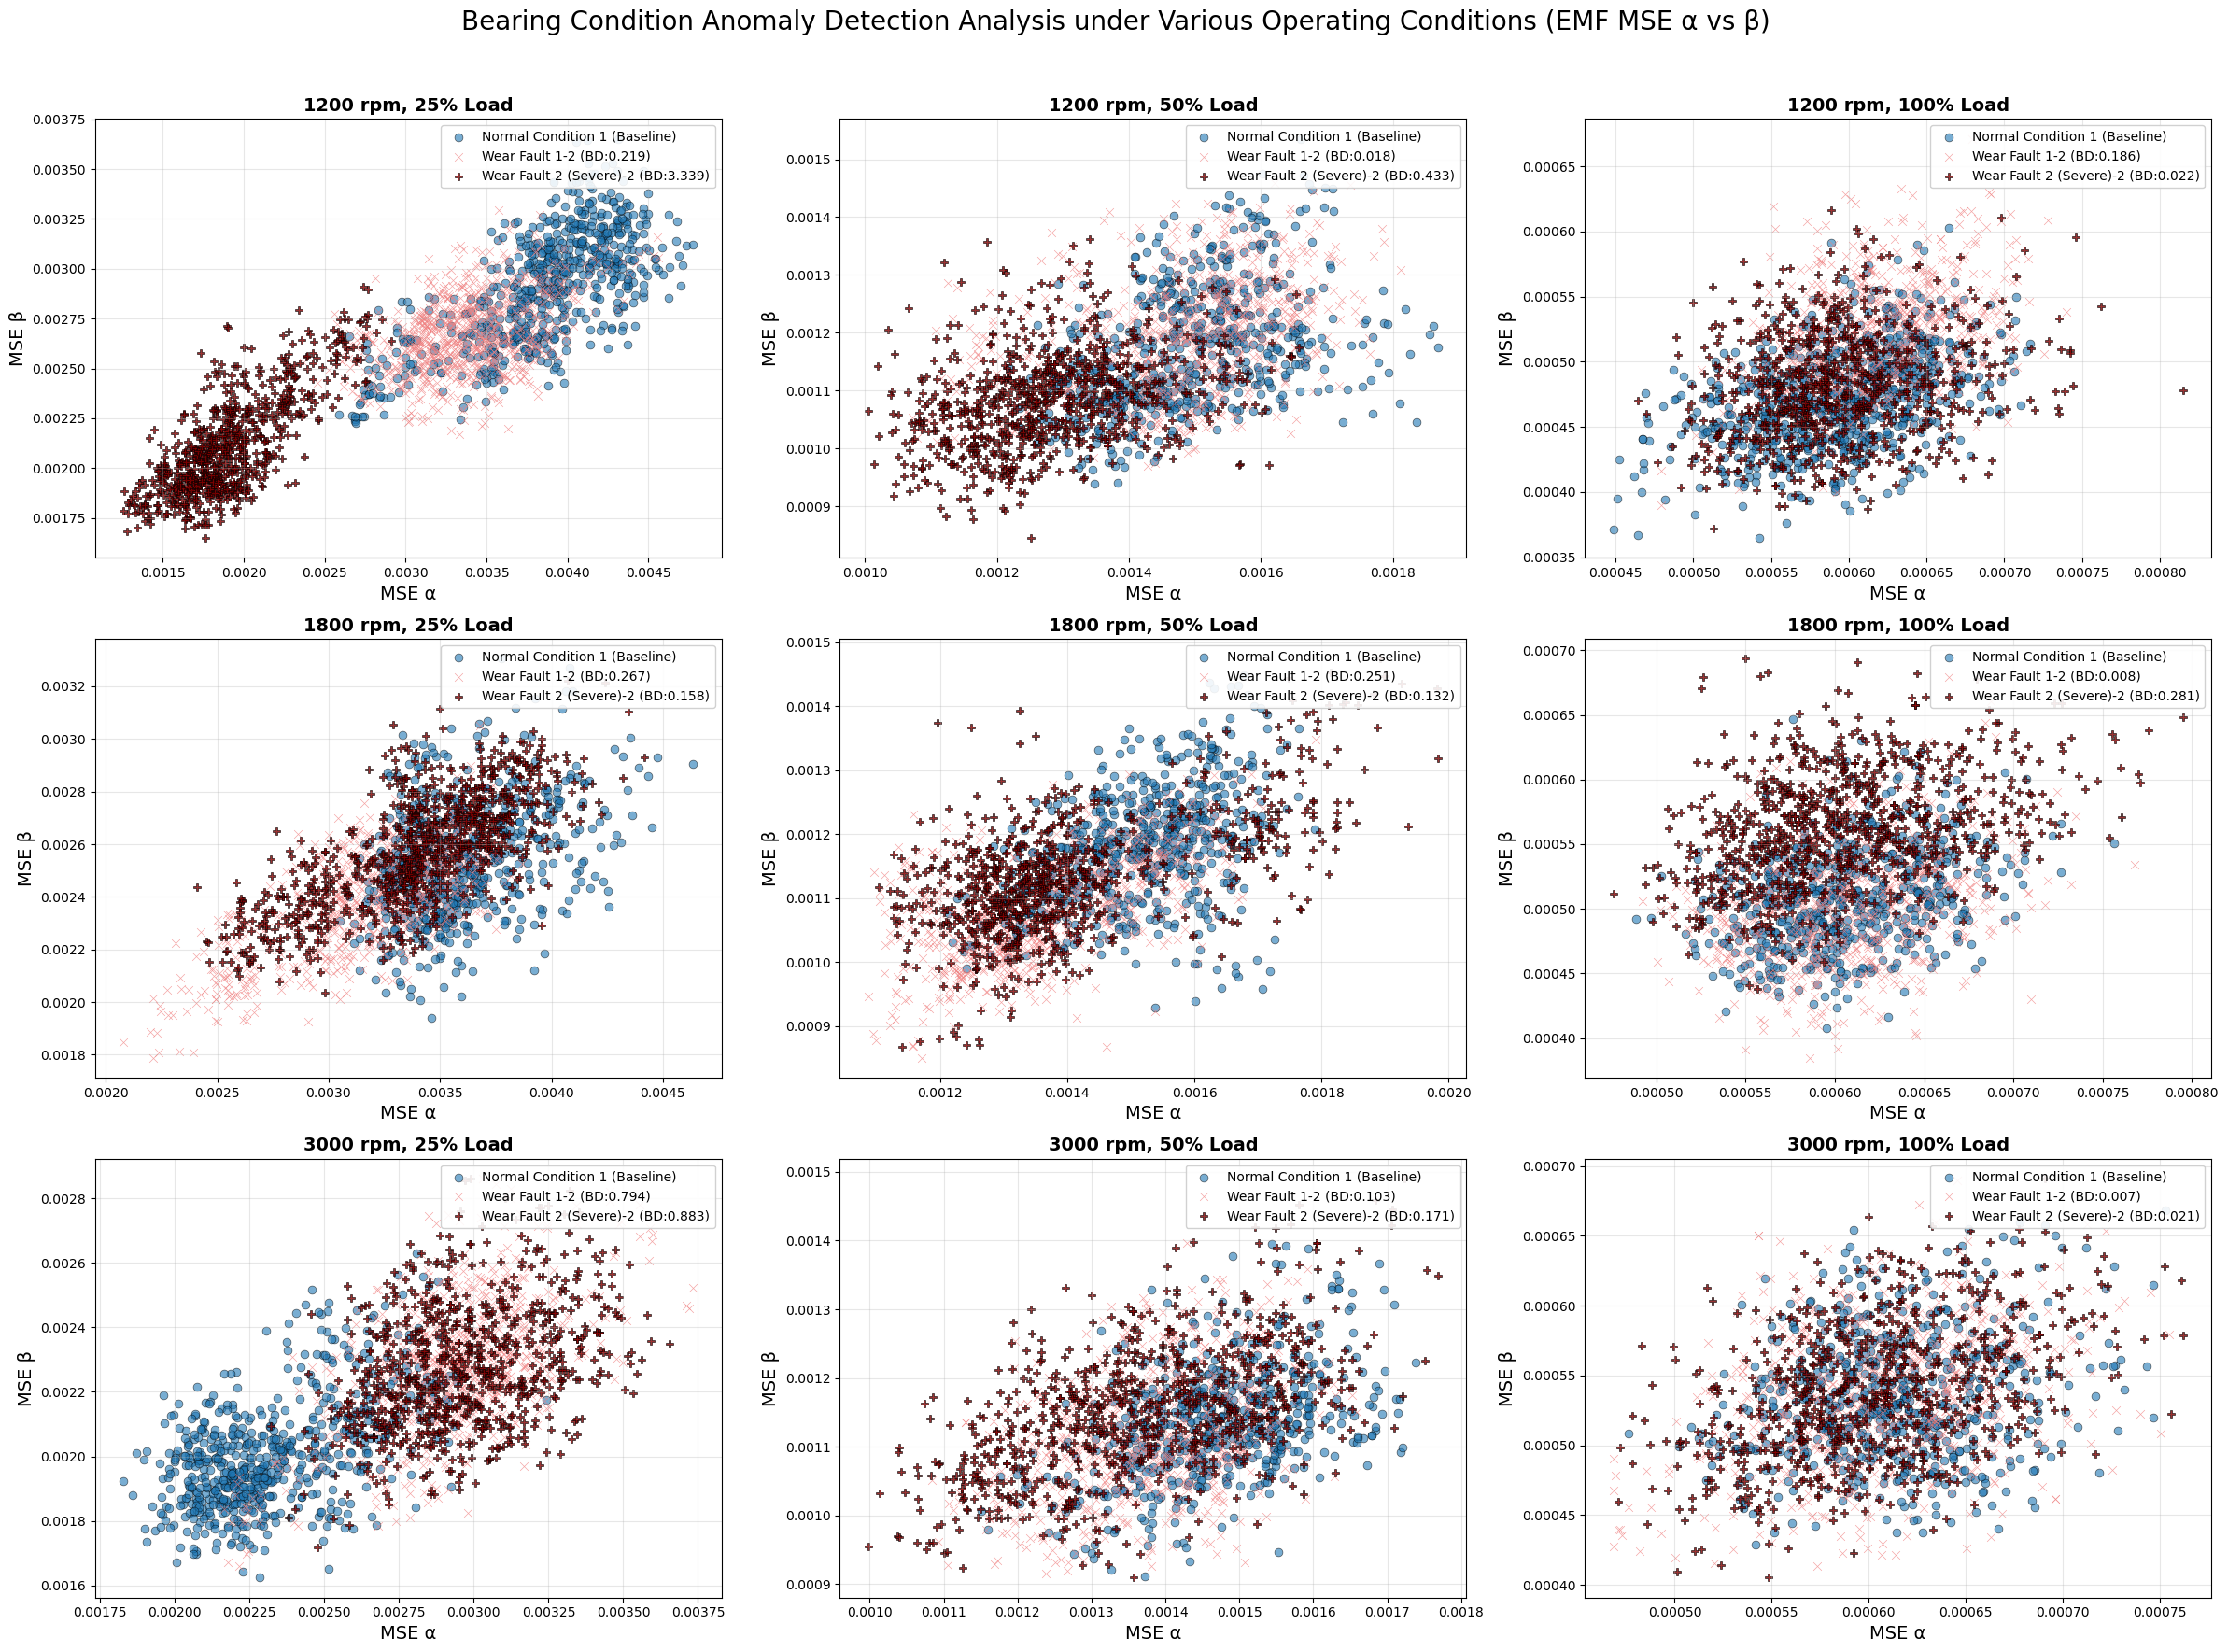


Anomaly Detection Results Summary for Each Operating Condition
(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)

🔧 1200 rpm, 25% Load
------------------------------------------------------------
   ❌ Normal Condition 1-2 | BD Distance: 0.3036 | Anomaly Rate: 0.100 (3/30)
   ❌ Normal Condition 2   | BD Distance: 0.0447 | Anomaly Rate: 0.000 (0/35)
   ❌ Normal Condition 2-2 | BD Distance: 0.0692 | Anomaly Rate: 0.000 (0/30)
   ❌ Drill Fault 2mm      | BD Distance: 0.1864 | Anomaly Rate: 0.312 (15/48)
   ❌ Drill Fault 2mm-2    | BD Distance: 0.1917 | Anomaly Rate: 0.000 (0/38)
   ❌ Wear Fault 1         | BD Distance: 1.7255 | Anomaly Rate: 0.938 (45/48)
   ✅ Wear Fault 1-2       | BD Distance: 0.2186 | Anomaly Rate: 0.050 (2/40)
   ❌ Wear Fault 2 (Severe) | BD Distance: 0.2188 | Anomaly Rate: 0.342 (13/38)
   ✅ Wear Fault 2 (Severe)-2 | BD Distance: 3.3395 | Anomaly Rate: 1.000 (38/38)

🔧 1200 rpm, 50% Load
--------------------------------------------------------

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """判斷樣本是否來自指定高斯分布（使用卡方檢定）"""
    samples = np.array(samples)
    mean = np.array(mean)
    cov = np.array(cov)
    
    # 計算馬氏距離平方
    inv_cov = np.linalg.inv(cov)
    diff = samples - mean
    m_dist2 = np.sum(diff @ inv_cov * diff, axis=1)
    
    # 卡方檢定
    test_stat = np.mean(m_dist2)
    p_value = 1 - chi2.cdf(test_stat, df=2)
    is_from_gaussian = p_value > alpha
    
    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_I_in_I_out
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_II = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_II[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_II[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_II.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

V in I out + res

模型訓練配置:
- 使用權重訓練: False
- 使用GPU: True
- 批次大小: 128
- 訓練週期: 50
- 驗證比例: 0.1

開始訓練模型: 0826_multiscale_CCAE_Base1024_VI_res
測試模型結構...
測試預測輸出形狀: (1, 1024, 2)
模型結構驗證通過，開始訓練...

⚖️ 使用均勻權重訓練
使用設備: /GPU:0

🚀 開始訓練 - 批次大小: 128, 週期: 50
Epoch 1/50
398/398 [==============================] - 10s 18ms/step - loss: 0.0092 - val_loss: 0.0062 - lr: 0.0010
Epoch 2/50
398/398 [==============================] - 8s 19ms/step - loss: 0.0056 - val_loss: 0.0051 - lr: 0.0010
Epoch 3/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0046 - val_loss: 0.0041 - lr: 0.0010
Epoch 4/50
398/398 [==============================] - 7s 17ms/step - loss: 0.0037 - val_loss: 0.0034 - lr: 0.0010
Epoch 5/50
398/398 [==============================] - 8s 19ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 0.0010
Epoch 6/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0031 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0030 - val_loss

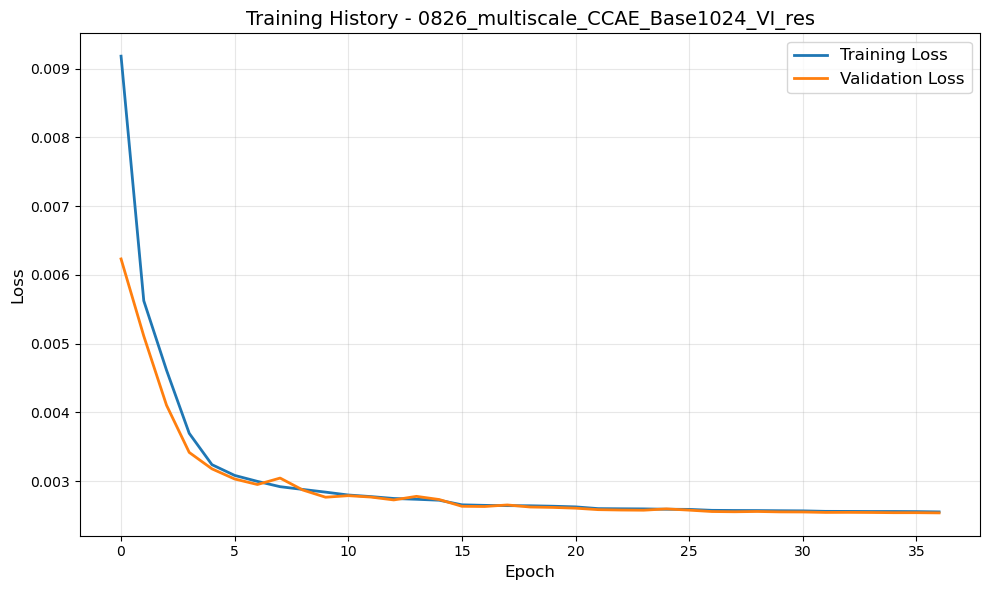

✅ 模型已儲存: NTU_rul_models\CCAE_models\0826_multiscale_CCAE_Base1024\0826_multiscale_CCAE_Base1024_VI_res.keras
✅ 訓練元數據已儲存: NTU_rul_models\CCAE_models\0826_multiscale_CCAE_Base1024\0826_multiscale_CCAE_Base1024_VI_res_metadata.json

🎉 VI 模型訓練完成!
最終訓練損失: 0.002404
最終驗證損失: 0.002387
最佳驗證損失: 0.002387


In [ ]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")

# 執行訓練
history_VI_res = train_model(
    model=my_model_V_in_I_out_res,
    model_suffix='_VI_res',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_currents_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VI_res = save_training_results(my_model_V_in_I_out_res, history_VI_res, '_VI_res')

print(f"\n🎉 VI 模型訓練完成!")
print(f"最終訓練損失: {metadata_VI['final_train_loss']:.6f}")
if metadata_VI['final_val_loss']:
    print(f"最終驗證損失: {metadata_VI['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VI['best_val_loss']:.6f}")

V in I out res + film

模型訓練配置:
- 使用權重訓練: False
- 使用GPU: True
- 批次大小: 128
- 訓練週期: 50
- 驗證比例: 0.1

開始訓練模型: 0826_multiscale_CCAE_Base1024_VI_res_cond
測試模型結構...
測試預測輸出形狀: (1, 1024, 2)
模型結構驗證通過，開始訓練...

⚖️ 使用均勻權重訓練
使用設備: /GPU:0

🚀 開始訓練 - 批次大小: 128, 週期: 50
Epoch 1/50
398/398 [==============================] - 16s 27ms/step - loss: 0.0112 - val_loss: 0.0052 - lr: 0.0010
Epoch 2/50
398/398 [==============================] - 9s 21ms/step - loss: 0.0044 - val_loss: 0.0037 - lr: 0.0010
Epoch 3/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0034 - val_loss: 0.0032 - lr: 0.0010
Epoch 4/50
398/398 [==============================] - 7s 19ms/step - loss: 0.0031 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0030 - val_loss: 0.0030 - lr: 0.0010
Epoch 6/50
398/398 [==============================] - 7s 18ms/step - loss: 0.0029 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/50
398/398 [==============================] - 8s 20ms/step - loss: 0.0029 - val

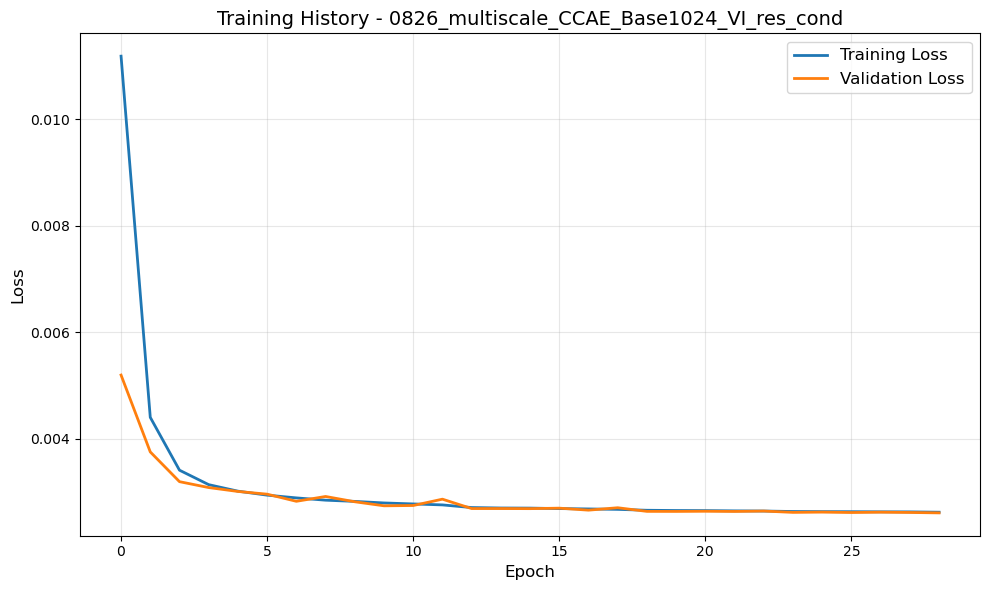

✅ 模型已儲存: NTU_rul_models\CCAE_models\0826_multiscale_CCAE_Base1024\0826_multiscale_CCAE_Base1024_VI_res_cond.keras
✅ 訓練元數據已儲存: NTU_rul_models\CCAE_models\0826_multiscale_CCAE_Base1024\0826_multiscale_CCAE_Base1024_VI_res_cond_metadata.json

🎉 VI 模型訓練完成!
最終訓練損失: 0.002616
最終驗證損失: 0.002603
最佳驗證損失: 0.002603


In [ ]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")

# 執行訓練
history_VI_res_cond = train_model(
    model=my_model_V_in_I_out_res_cond,
    model_suffix='_VI_res_cond',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_currents_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VI_res_cond = save_training_results(my_model_V_in_I_out_res_cond, history_VI_res_cond, '_VI_res_cond')

print(f"\n🎉 VI 模型訓練完成!")
print(f"最終訓練損失: {metadata_VI_res_cond['final_train_loss']:.6f}")
if metadata_VI_res_cond['final_val_loss']:
    print(f"最終驗證損失: {metadata_VI_res_cond['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VI_res_cond['best_val_loss']:.6f}")

計算各工況的重建MSE...
可用工況: ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
處理工況: Normal1
  ✅ Normal1 完成
處理工況: Normal1-2
  ✅ Normal1 完成
處理工況: Normal1-2
  ✅ Normal1-2 完成
處理工況: Normal2
  ✅ Normal1-2 完成
處理工況: Normal2
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm
  ✅ Normal2 完成
處理工況: Normal2-2
  ✅ Normal2 完成
處理工況: Normal2-2
  ✅ Normal2-2 完成
處理工況: drill_2mm_q1mm
  ✅ Normal2-2 完成
處理工況: drill_2mm_q1mm
  ✅ drill_2mm_q1mm 完成
處理工況: drill_2mm_q1mm_2
  ✅ drill_2mm_q1mm 完成
處理工況: drill_2mm_q1mm_2
  ✅ drill_2mm_q1mm_2 完成
處理工況: wear_out_1
  ✅ drill_2mm_q1mm_2 完成
處理工況: wear_out_1
  ✅ wear_out_1 完成
處理工況: wear_out_1_2
  ✅ wear_out_1 完成
處理工況: wear_out_1_2
  ✅ wear_out_1_2 完成
處理工況: wear_out_2_worse
  ✅ wear_out_1_2 完成
處理工況: wear_out_2_worse
  ✅ wear_out_2_worse 完成
處理工況: wear_out_2_worse_2
  ✅ wear_out_2_worse 完成
處理工況: wear_out_2_worse_2
  ✅ wear_out_2_worse_2 完成

開始按運轉條件繪圖...


C:\Users\MotorTech\AppData\Local\Temp\ipykernel_15700\1959074418.py:418: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_test, y_test,


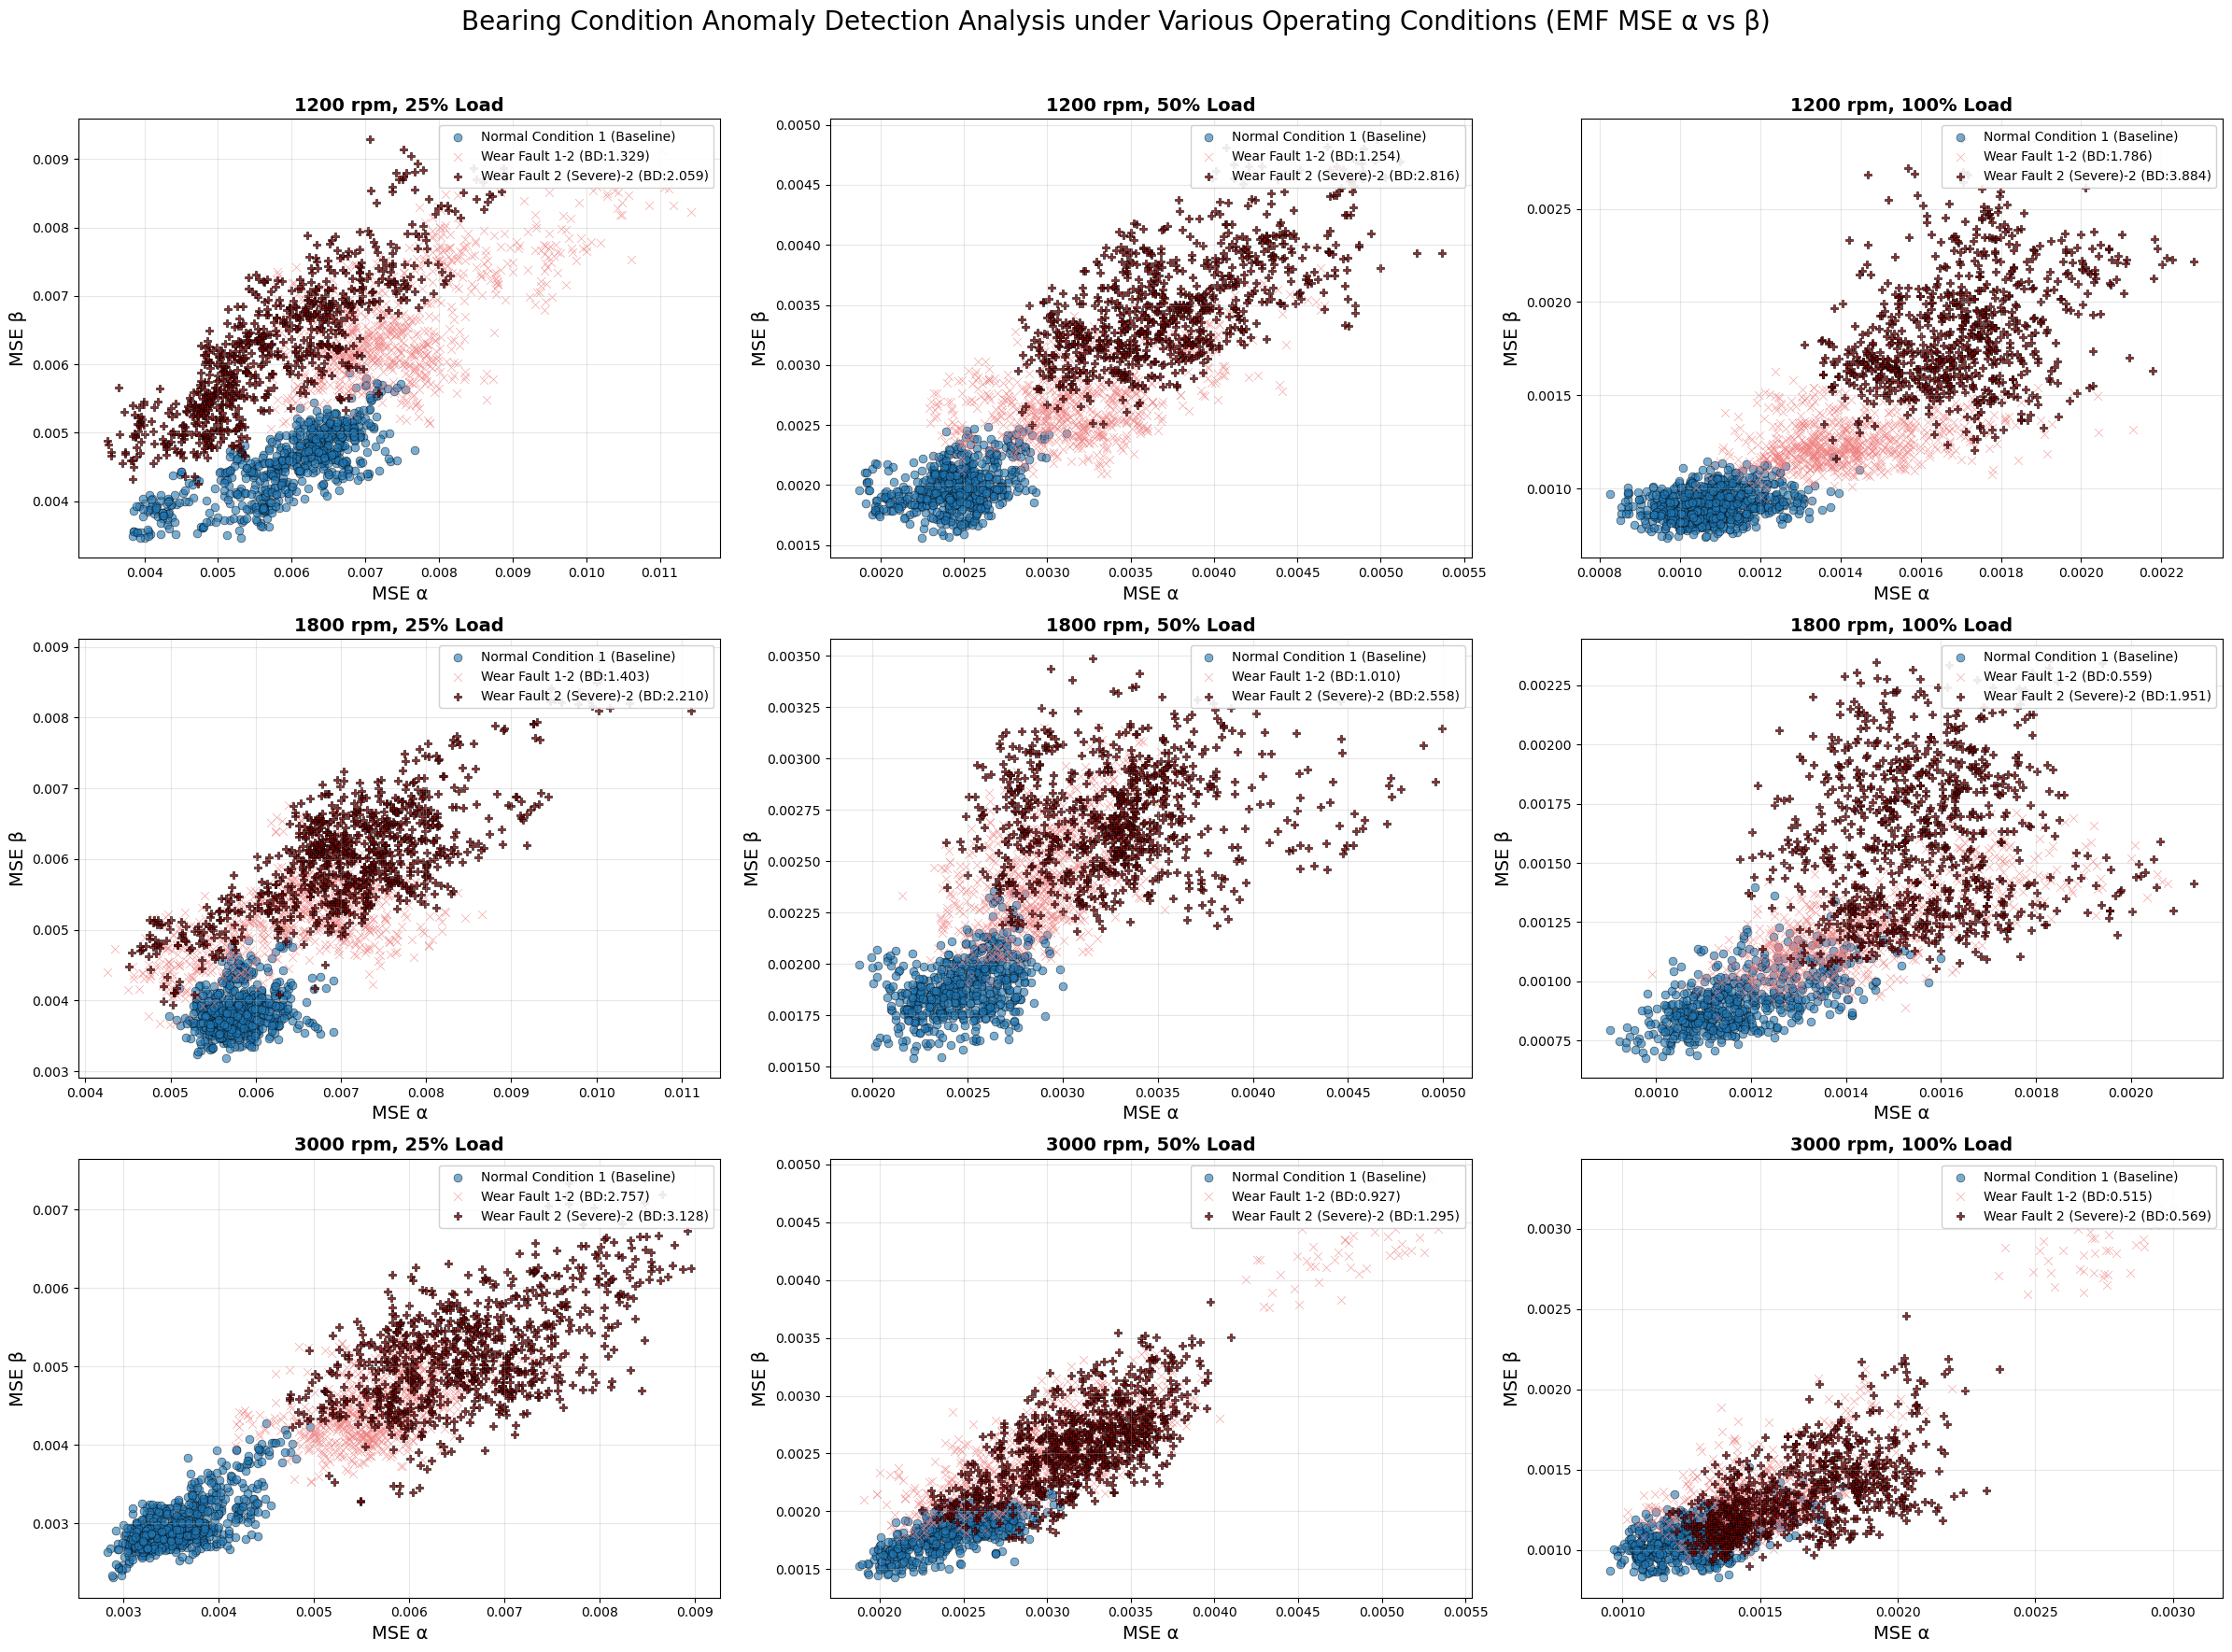


Anomaly Detection Results Summary for Each Operating Condition
(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)

🔧 1200 rpm, 25% Load
------------------------------------------------------------
   ❌ Normal Condition 1-2 | BD Distance: 1.2330 | Anomaly Rate: 0.800 (24/30)
   ❌ Normal Condition 2   | BD Distance: 0.2871 | Anomaly Rate: 0.171 (6/35)
   ❌ Normal Condition 2-2 | BD Distance: 0.1099 | Anomaly Rate: 0.033 (1/30)
   ❌ Drill Fault 2mm      | BD Distance: 1.6303 | Anomaly Rate: 1.000 (48/48)
   ❌ Drill Fault 2mm-2    | BD Distance: 2.1064 | Anomaly Rate: 1.000 (38/38)
   ❌ Wear Fault 1         | BD Distance: 0.2721 | Anomaly Rate: 0.167 (8/48)
   ✅ Wear Fault 1-2       | BD Distance: 1.3287 | Anomaly Rate: 1.000 (40/40)
   ❌ Wear Fault 2 (Severe) | BD Distance: 1.7679 | Anomaly Rate: 1.000 (38/38)
   ✅ Wear Fault 2 (Severe)-2 | BD Distance: 2.0589 | Anomaly Rate: 1.000 (38/38)

🔧 1200 rpm, 50% Load
------------------------------------------------------

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """判斷樣本是否來自指定高斯分布（使用卡方檢定）"""
    samples = np.array(samples)
    mean = np.array(mean)
    cov = np.array(cov)
    
    # 計算馬氏距離平方
    inv_cov = np.linalg.inv(cov)
    diff = samples - mean
    m_dist2 = np.sum(diff @ inv_cov * diff, axis=1)
    
    # 卡方檢定
    test_stat = np.mean(m_dist2)
    p_value = 1 - chi2.cdf(test_stat, df=2)
    is_from_gaussian = p_value > alpha
    
    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out_res
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI_res = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI_res[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI_res[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI_res.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

## 📊 Plot Control 機制修改說明

### 🔄 **修改後的資料處理機制**

修改後的程式碼將**資料分析與儲存**和**視覺化顯示**完全分離：

#### 📈 **資料分析與儲存 (不受 plot control 影響)**
- ✅ **所有軸承工況**都會被分析並計算統計指標
- ✅ **完整結果**都會存入 `operating_condition_results_VI_res`
- ✅ 包括 BD Distance、Member Statistics 等所有分析結果
- ✅ 資料完整性不受顯示設定影響

#### 🎨 **視覺化顯示 (受 plot control 控制)**
- 🔹 `condition_plot_control` 只控制在圖表上的**顯示/隱藏**
- 🔹 `True` = 在圖上顯示該工況的散點圖
- 🔹 `False` = 隱藏該工況的散點圖（但仍分析和存儲資料）

### 📋 **結果摘要改進**
- 結果表格顯示**所有存儲的結果**
- 用 ✅/❌ 標示該工況是否在圖上顯示
- 提供完整的統計資訊，不論顯示狀態

### 💡 **優點**
1. **資料完整性**: 所有工況都被分析，無遺漏
2. **靈活顯示**: 可隨時調整圖表顯示內容而不需重新分析
3. **後續分析**: 完整資料可用於進一步的統計分析和比較
4. **效率提升**: 一次分析，多次使用不同的顯示配置

計算各工況的重建MSE...
可用工況: ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm

開始按運轉條件繪圖...
使用 'Normal1' 作為基準正常工況

開始按運轉條件繪圖...
使用 'Normal1' 作為基準正常工況


C:\Users\MotorTech\AppData\Local\Temp\ipykernel_15700\973945845.py:418: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_test, y_test,


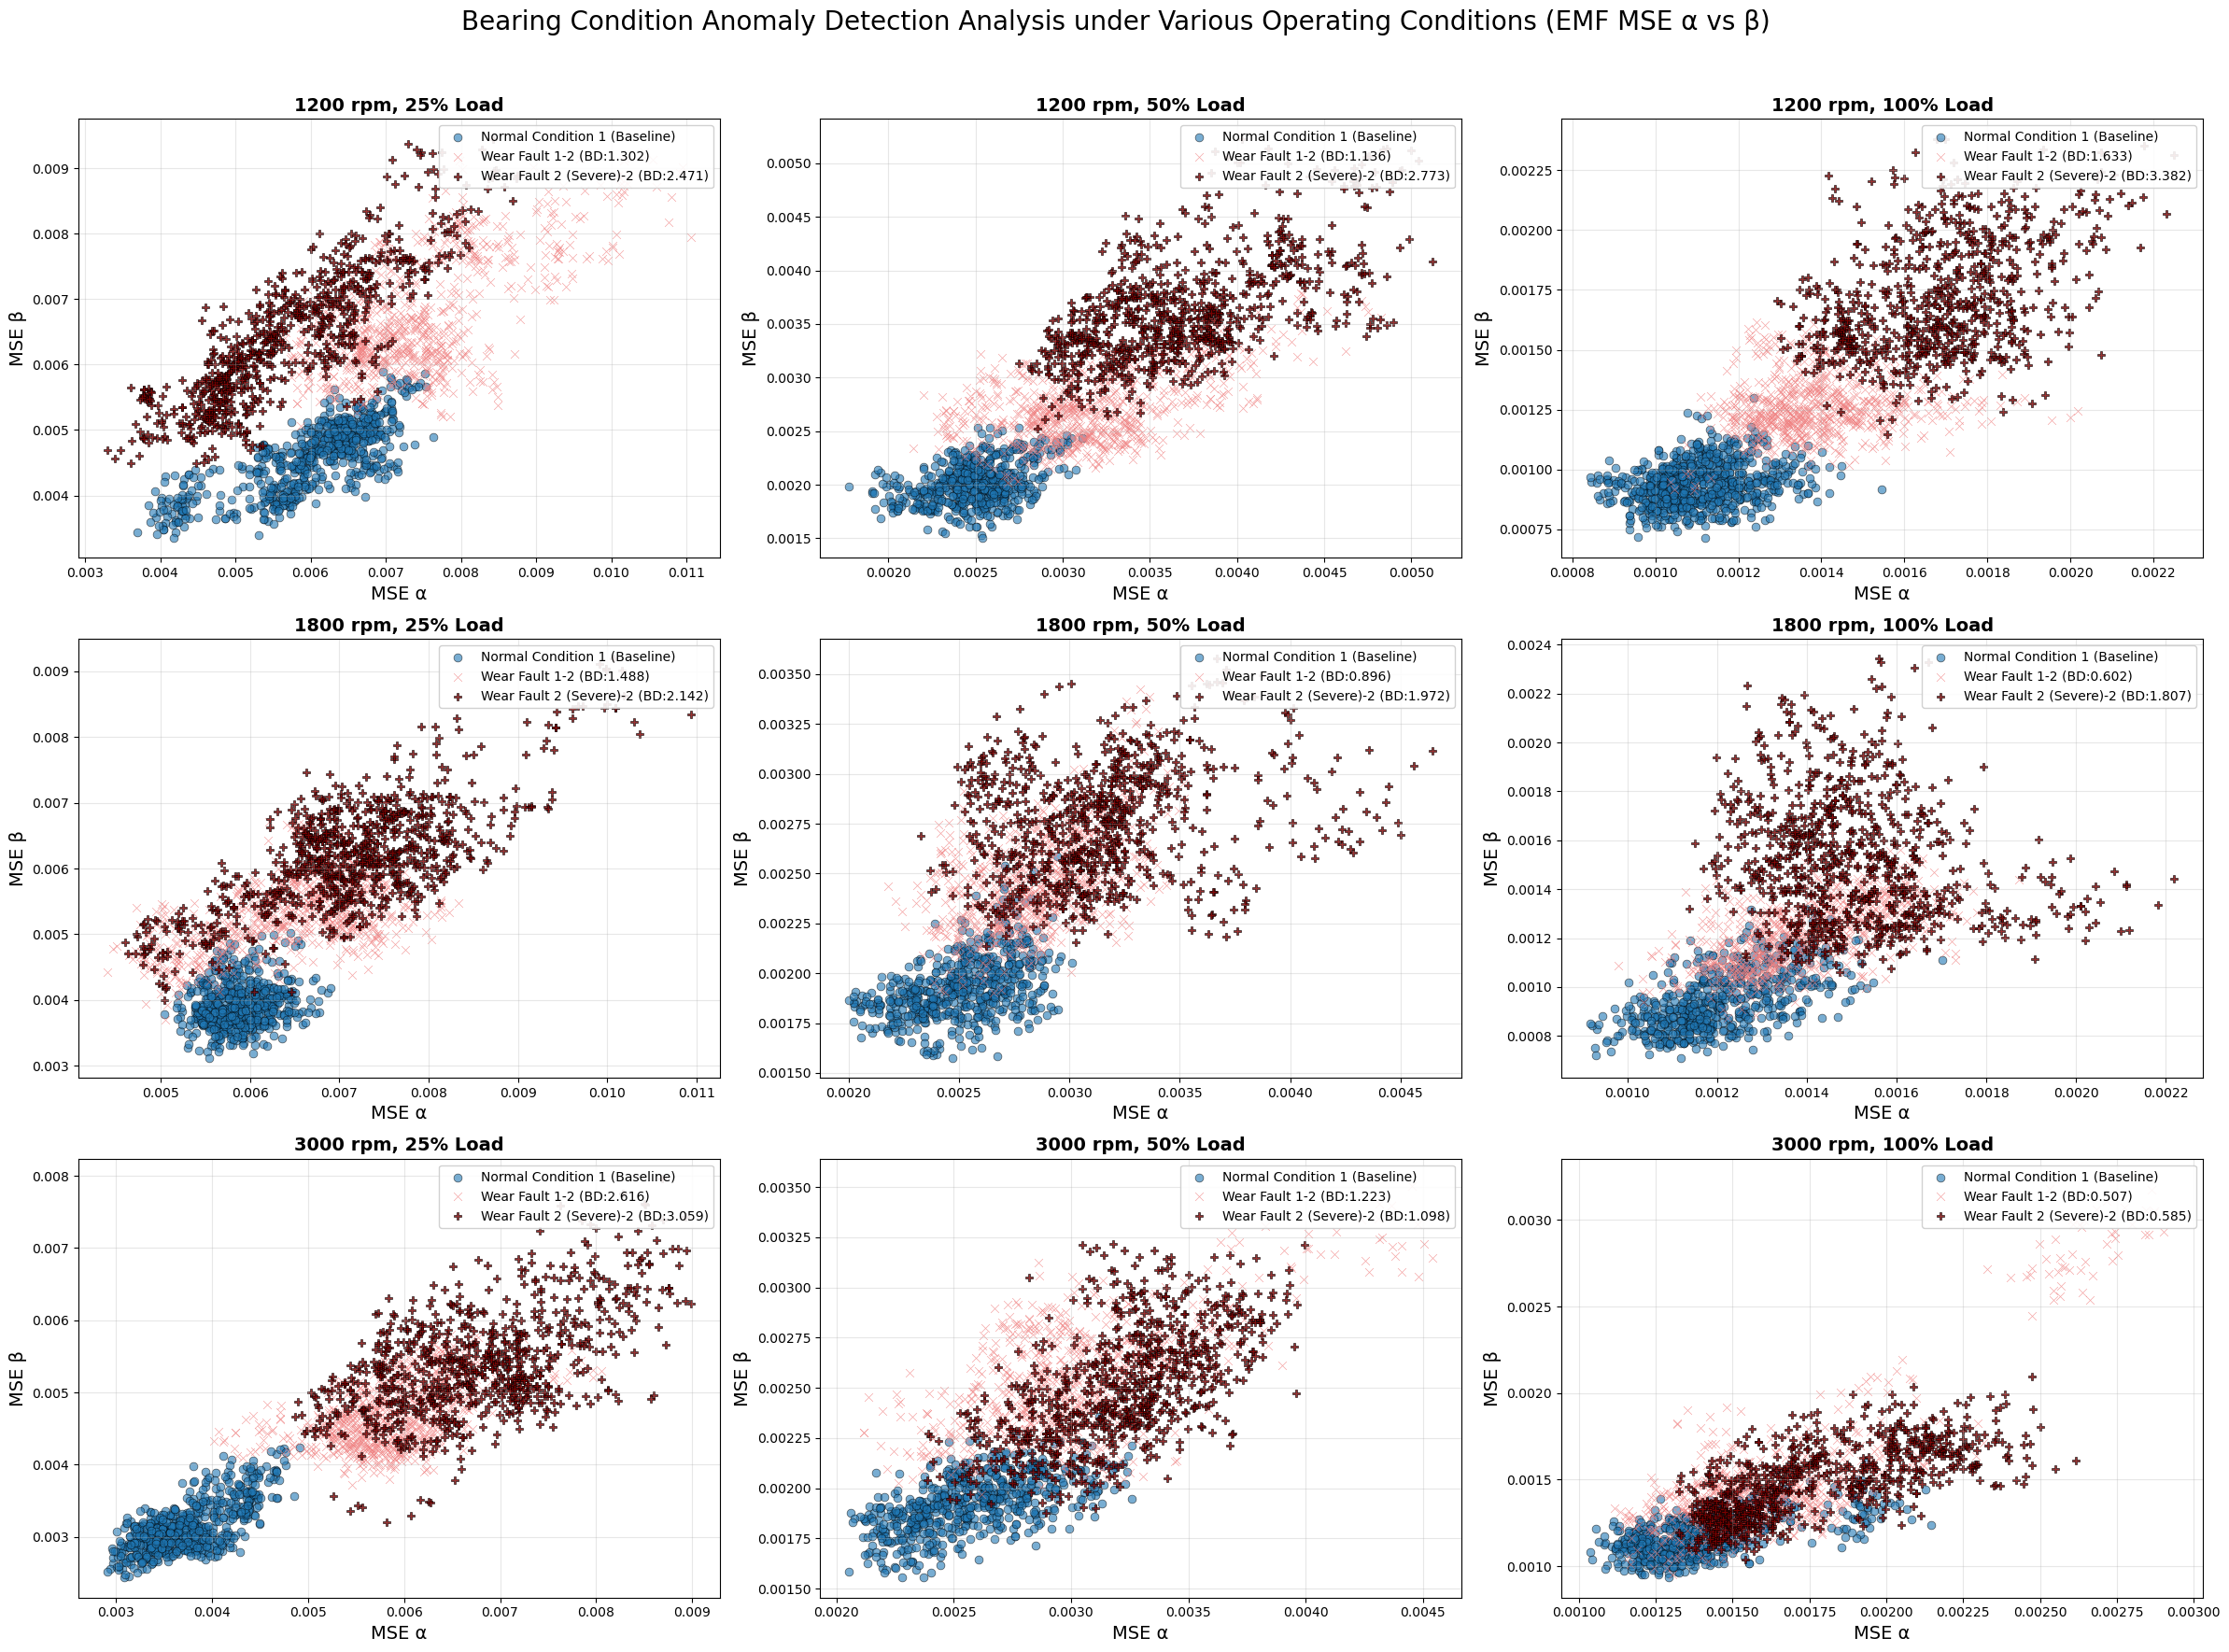


Anomaly Detection Results Summary for Each Operating Condition
(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)

🔧 1200 rpm, 25% Load
------------------------------------------------------------
   ❌ Normal Condition 1-2 | BD Distance: 1.1756 | Anomaly Rate: 0.800 (24/30)
   ❌ Normal Condition 2   | BD Distance: 0.2504 | Anomaly Rate: 0.086 (3/35)
   ❌ Normal Condition 2-2 | BD Distance: 0.0793 | Anomaly Rate: 0.000 (0/30)
   ❌ Drill Fault 2mm      | BD Distance: 1.6507 | Anomaly Rate: 1.000 (48/48)
   ❌ Drill Fault 2mm-2    | BD Distance: 2.0005 | Anomaly Rate: 1.000 (38/38)
   ❌ Wear Fault 1         | BD Distance: 0.2591 | Anomaly Rate: 0.146 (7/48)
   ✅ Wear Fault 1-2       | BD Distance: 1.3015 | Anomaly Rate: 1.000 (40/40)
   ❌ Wear Fault 2 (Severe) | BD Distance: 1.7700 | Anomaly Rate: 1.000 (38/38)
   ✅ Wear Fault 2 (Severe)-2 | BD Distance: 2.4706 | Anomaly Rate: 1.000 (38/38)

🔧 1200 rpm, 50% Load
------------------------------------------------------

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """判斷樣本是否來自指定高斯分布（使用卡方檢定）"""
    samples = np.array(samples)
    mean = np.array(mean)
    cov = np.array(cov)
    
    # 計算馬氏距離平方
    inv_cov = np.linalg.inv(cov)
    diff = samples - mean
    m_dist2 = np.sum(diff @ inv_cov * diff, axis=1)
    
    # 卡方檢定
    test_stat = np.mean(m_dist2)
    p_value = 1 - chi2.cdf(test_stat, df=2)
    is_from_gaussian = p_value > alpha
    
    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out_res_cond
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI_res_cond = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI_res_cond[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI_res_cond[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI_res_cond.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

=== 檢查 operating_condition_results_VI_res 資料結構 ===
可用運轉條件: ['1200 0.5v', '1200 1.0v', '1200 2.0v', '1800 0.5v', '1800 1.0v', '1800 2.0v', '3000 0.5v', '3000 1.0v', '3000 2.0v']
第一個運轉條件 (1200 0.5v) 的結構:
  比較軸承工況: ['Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  第一個軸承工況 (Normal1-2) 的統計資料:
    member_in: 6
    member_out: 24
    member_out_rate: 0.8

可用的運轉條件 (9個):
  1200 0.5v -> 1200 0.5V
  1200 1.0v -> 1200 1.0V
  1200 2.0v -> 1200 2.0V
  1800 0.5v -> 1800 0.5V
  1800 1.0v -> 1800 1.0V
  1800 2.0v -> 1800 2.0V
  3000 0.5v -> 3000 0.5V
  3000 1.0v -> 3000 1.0V
  3000 2.0v -> 3000 2.0V

Y軸範圍: 0 - 115.0%

正在生成基於 operating_condition_results_VI_res 的軸承狀態準確率比較圖...


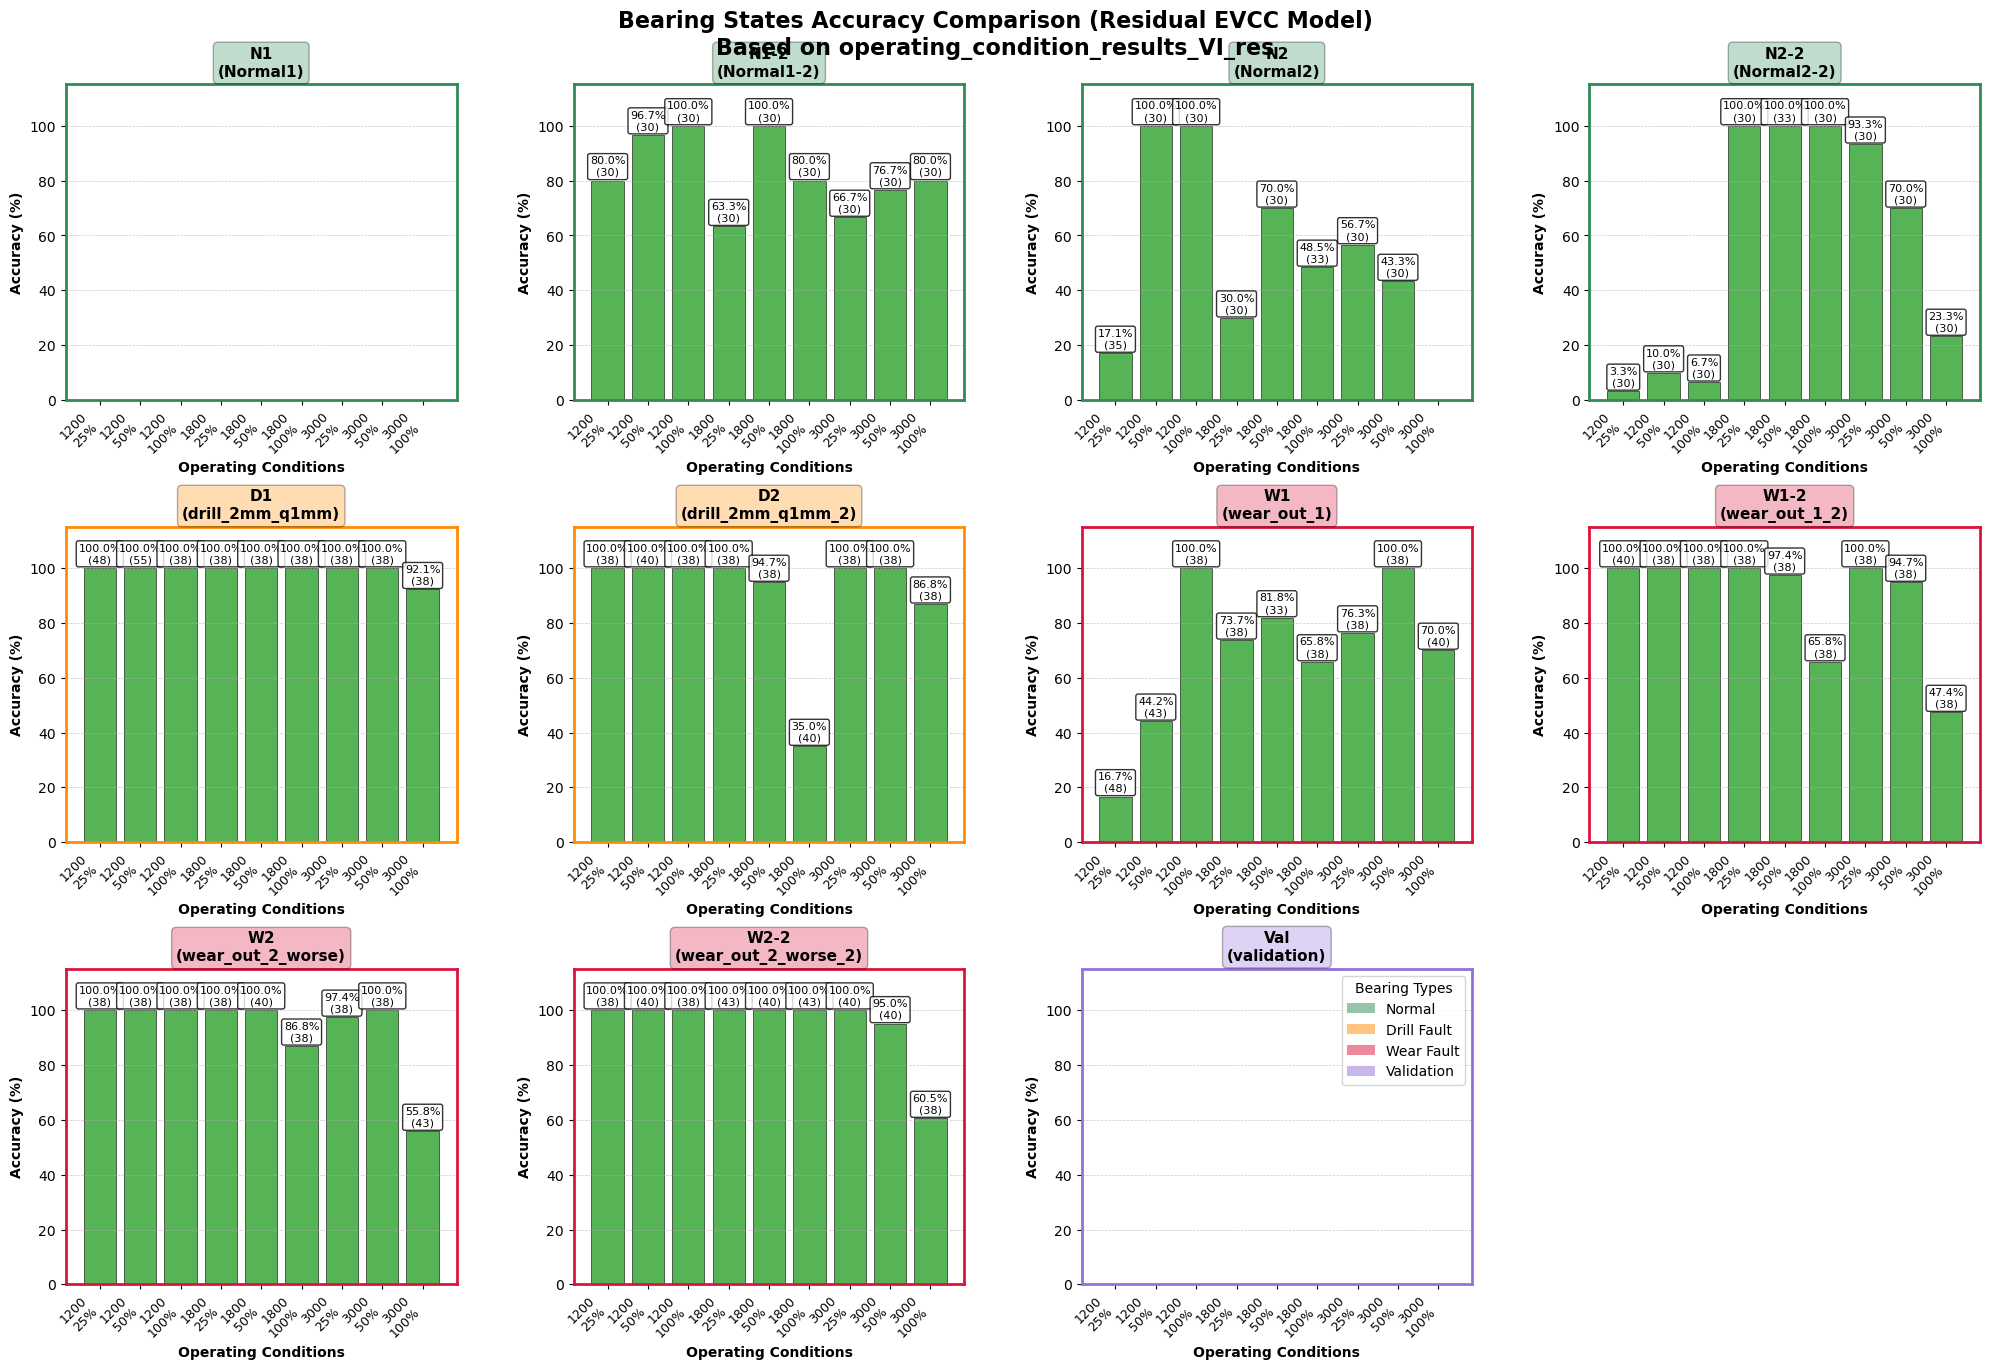

In [ ]:
# ===== 使用 operating_condition_results_VI_res 創建軸承狀態準確率比較圖 =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ===== 資料來源: operating_condition_results_VI_res =====
print("=== 檢查 operating_condition_results_VI_res 資料結構 ===")
print(f"可用運轉條件: {list(operating_condition_results_VI_res.keys())}")

# 檢查第一個運轉條件的資料結構
if operating_condition_results_VI_res:
    first_op_cond = next(iter(operating_condition_results_VI_res.keys()))
    print(f"第一個運轉條件 ({first_op_cond}) 的結構:")
    if 'comparisons' in operating_condition_results_VI_res[first_op_cond]:
        comparisons = operating_condition_results_VI_res[first_op_cond]['comparisons']
        print(f"  比較軸承工況: {list(comparisons.keys())}")
        
        # 檢查第一個比較工況的資料結構
        if comparisons:
            first_bearing = next(iter(comparisons.keys()))
            print(f"  第一個軸承工況 ({first_bearing}) 的統計資料:")
            if 'member_stats' in comparisons[first_bearing]:
                member_stats = comparisons[first_bearing]['member_stats']
                print(f"    member_in: {member_stats.get('members_in', 'N/A')}")
                print(f"    member_out: {member_stats.get('members_out', 'N/A')}")
                print(f"    member_out_rate: {member_stats.get('members_out_rate', 'N/A')}")

# ===== 從 operating_condition_results_VI_res 提取資料 =====
def extract_bearing_accuracy_from_VI_res(op_results):
    """從 operating_condition_results_VI_res 提取軸承狀態準確率資料"""
    accuracy_data = {}
    
    for op_cond, op_data in op_results.items():
        if 'comparisons' not in op_data:
            continue
            
        accuracy_data[op_cond] = {}
        
        for bearing_cond, comparison_data in op_data['comparisons'].items():
            if 'member_stats' not in comparison_data:
                continue
                
            member_stats = comparison_data['member_stats']
            # 計算準確率 (members_out_rate 轉換為百分比)
            out_rate = member_stats.get('members_out_rate', 0)
            accuracy_rate = out_rate * 100 if out_rate <= 1.0 else out_rate
            
            accuracy_data[op_cond][bearing_cond] = {
                'accuracy': accuracy_rate,
                'members_in': member_stats.get('members_in', 0),
                'members_out': member_stats.get('members_out', 0),
                'total_samples': member_stats.get('members_in', 0) + member_stats.get('members_out', 0)
            }
    
    return accuracy_data

# 提取資料
vi_res_accuracy_data = extract_bearing_accuracy_from_VI_res(operating_condition_results_VI_res)

# ===== 軸承狀態定義 =====
bearing_states = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 
                 'drill_2mm_q1mm', 'drill_2mm_q1mm_2',
                 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2',
                 'validation']

bearing_labels = {
    'Normal1': 'N1', 'Normal1-2': 'N1-2', 'Normal2': 'N2', 'Normal2-2': 'N2-2',
    'drill_2mm_q1mm': 'D1', 'drill_2mm_q1mm_2': 'D2', 
    'wear_out_1': 'W1', 'wear_out_1_2': 'W1-2',
    'wear_out_2_worse': 'W2', 'wear_out_2_worse_2': 'W2-2',
    'validation': 'Val'
}

# ===== 運轉條件映射 =====
operating_condition_mapping = {
    '1200 0.5v': '1200 0.5V', '1200 1.0v': '1200 1.0V', '1200 2.0v': '1200 2.0V',
    '1800 0.5v': '1800 0.5V', '1800 1.0v': '1800 1.0V', '1800 2.0v': '1800 2.0V',
    '3000 0.5v': '3000 0.5V', '3000 1.0v': '3000 1.0V', '3000 2.0v': '3000 2.0V'
}

operating_short_labels = {
    '1200 0.5V': '1200\n25%', '1200 1.0V': '1200\n50%', '1200 2.0V': '1200\n100%',
    '1800 0.5V': '1800\n25%', '1800 1.0V': '1800\n50%', '1800 2.0V': '1800\n100%',
    '3000 0.5V': '3000\n25%', '3000 1.0V': '3000\n50%', '3000 2.0V': '3000\n100%'
}

# ===== 狀態類型和顏色 =====
bearing_state_types = {
    'Normal1': 'normal', 'Normal1-2': 'normal', 'Normal2': 'normal', 'Normal2-2': 'normal',
    'drill_2mm_q1mm': 'drill', 'drill_2mm_q1mm_2': 'drill',
    'wear_out_1': 'wear', 'wear_out_1_2': 'wear', 'wear_out_2_worse': 'wear', 'wear_out_2_worse_2': 'wear',
    'validation': 'validation'
}

type_colors = {
    'normal': '#2E8B57',      # 海綠色
    'drill': '#FF8C00',       # 深橙色
    'wear': '#DC143C',        # 深紅色
    'validation': '#9370DB'   # 紫色
}

# ===== 檢查可用的運轉條件 =====
available_op_conditions = []
for orig_cond in vi_res_accuracy_data.keys():
    mapped_cond = operating_condition_mapping.get(orig_cond, orig_cond)
    if mapped_cond in operating_short_labels:
        available_op_conditions.append((orig_cond, mapped_cond))

print(f"\n可用的運轉條件 ({len(available_op_conditions)}個):")
for orig, mapped in available_op_conditions:
    print(f"  {orig} -> {mapped}")

# ===== 收集所有準確率數值以確定 Y 軸範圍 =====
all_accuracy_values = []
for op_cond, bearing_data in vi_res_accuracy_data.items():
    for bearing_state, stats in bearing_data.items():
        if bearing_state in bearing_states:
            accuracy = stats.get('accuracy', 0)
            if not np.isnan(accuracy) and accuracy > 0:
                all_accuracy_values.append(accuracy)

y_max = max(all_accuracy_values) * 1.15 if all_accuracy_values else 100.0
print(f"\nY軸範圍: 0 - {y_max:.1f}%")

# ===== 創建圖表 =====
print(f"\n正在生成基於 operating_condition_results_VI_res 的軸承狀態準確率比較圖...")

# 計算子圖佈局 (11個軸承狀態)
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.suptitle("Bearing States Accuracy Comparison (Residual EVCC Model)\nBased on operating_condition_results_VI_res", 
             fontsize=16, fontweight="bold", y=0.95)

# 扁平化 axes 數組
axes_flat = axes.flatten()

# ===== 為每個軸承狀態創建子圖 =====
for state_idx, bearing_state in enumerate(bearing_states):
    ax = axes_flat[state_idx]
    
    # 準備資料
    op_conditions_for_plot = []
    accuracy_values = []
    sample_counts = []
    
    for orig_op_cond, mapped_op_cond in available_op_conditions:
        if (orig_op_cond in vi_res_accuracy_data and 
            bearing_state in vi_res_accuracy_data[orig_op_cond]):
            
            stats = vi_res_accuracy_data[orig_op_cond][bearing_state]
            accuracy = stats.get('accuracy', 0)
            total_samples = stats.get('total_samples', 0)
            
            op_conditions_for_plot.append(mapped_op_cond)
            accuracy_values.append(accuracy)
            sample_counts.append(total_samples)
        else:
            op_conditions_for_plot.append(mapped_op_cond)
            accuracy_values.append(0)
            sample_counts.append(0)
    
    # 繪製柱狀圖
    x_positions = np.arange(len(op_conditions_for_plot))
    bars = ax.bar(x_positions, accuracy_values, 
                  color='#2ca02c',  # Residual EVCC 的顏色
                  alpha=0.8,
                  edgecolor='black', 
                  linewidth=0.5)
    
    # 在柱頂添加數值標籤
    for i, (bar, accuracy, samples) in enumerate(zip(bars, accuracy_values, sample_counts)):
        if accuracy > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + y_max*0.01,
                   f'{accuracy:.1f}%\n({samples})',
                   ha='center', va='bottom', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    # 設定子圖屬性
    state_type = bearing_state_types.get(bearing_state, 'normal')
    state_color = type_colors.get(state_type, '#808080')
    
    ax.set_xlabel('Operating Conditions', fontsize=10, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
    ax.set_title(f"{bearing_labels.get(bearing_state, bearing_state)}\n({bearing_state})", 
                fontsize=11, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor=state_color, alpha=0.3))
    ax.set_xticks(x_positions)
    ax.set_xticklabels([operating_short_labels.get(op, op) for op in op_conditions_for_plot], 
                      rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, y_max)
    ax.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.5)
    
    # 添加邊框顏色以區分狀態類型
    for spine in ax.spines.values():
        spine.set_color(state_color)
        spine.set_linewidth(2)

# 隱藏最後一個空的子圖
axes_flat[11].set_visible(False)

# 添加狀態類型圖例
state_handles = [
    Rectangle((0,0),1,1, facecolor=type_colors['normal'], alpha=0.5, label='Normal'),
    Rectangle((0,0),1,1, facecolor=type_colors['drill'], alpha=0.5, label='Drill Fault'),
    Rectangle((0,0),1,1, facecolor=type_colors['wear'], alpha=0.5, label='Wear Fault'),
    Rectangle((0,0),1,1, facecolor=type_colors['validation'], alpha=0.5, label='Validation')
]
state_legend = axes_flat[10].legend(handles=state_handles, loc='upper right', 
                                   fontsize=10, title='Bearing Types',
                                   bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.10, hspace=0.4, wspace=0.3)
plt.show()

# print("✅ 基於 operating_condition_results_VI_res 的軸承狀態準確率比較圖完成")
# print("\n📊 圖表說明:")
# print("- 資料來源: operating_condition_results_VI_res (Residual EVCC 模型)")
# print("- 佈局: 3×4 子圖陣列，每個子圖代表一個軸承狀態")
# print("- X軸: 9種運轉條件 (3轉速 × 3負載)")
# print("- Y軸: 準確率百分比")
# print("- 綠色柱狀圖: Residual EVCC 模型的檢測準確率")
# print("- 邊框顏色: 區分軸承狀態類型")
# print("  🟢 綠色邊框: 正常狀態")
# print("  🟠 橙色邊框: 鑽孔故障")
# print("  🔴 紅色邊框: 磨耗故障")
# print("  🟣 紫色邊框: 驗證狀態")
# print("- 柱頂標籤: 準確率百分比和樣本數量")

In [ ]:
# operating_condition_results_VI_res["1200 0.5v"]['comparisons']['wear_out_1_2']['member_stats']
operating_condition_results_II
operating_condition_results_VI
operating_condition_results_VI_res
operating_condition_results_VI_res_cond

# member_stats = comparisons[first_bearing]['member_stats']

# === 檢查 operating_condition_results_VI_res 資料結構 ===
# 可用運轉條件: ['1200 0.5v', '1200 1.0v', '1200 2.0v', '1800 0.5v', '1800 1.0v', '1800 2.0v', '3000 0.5v', '3000 1.0v', '3000 2.0v']
# 第一個運轉條件 (1200 0.5v) 的結構:
#   比較軸承工況: ['wear_out_1_2', 'wear_out_2_worse_2']
#   第一個軸承工況 (wear_out_1_2) 的統計資料:
#     member_in: N/A
#     member_out: N/A
#     member_out_rate: N/A

{'baseline': 'Normal1',
 'comparisons': {'wear_out_1_2': {'bd_distance': 1.3287445964546167,
   'member_stats': {'members_in': 0,
    'members_out': 40,
    'members_out_rate': 1.0}},
  'wear_out_2_worse_2': {'bd_distance': 2.0588556697201783,
   'member_stats': {'members_in': 0,
    'members_out': 38,
    'members_out_rate': 1.0}}}}

### Performance 比較 ###

## 🎯 通用畫圖函數 - 適用於四個資料集

將軸承狀態準確率比較圖的畫圖方法套用到四個資料集：
- `operating_condition_results_II` (Current → Current)
- `operating_condition_results_VI` (EMF → Current) 
- `operating_condition_results_VI_res` (EMF → Current + Residual)
- `operating_condition_results_VI_res_cond` (EMF → Current + Residual + Conditional)

In [11]:
# ===== 通用軸承狀態準確率比較圖畫圖函數 =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def create_bearing_accuracy_comparison(operating_results, dataset_name, model_color='#2ca02c', 
                                     suptitle_prefix="Bearing States Accuracy Comparison"):
    """
    通用函數：為任何 operating_condition_results 資料集創建軸承狀態準確率比較圖
    
    Parameters:
    -----------
    operating_results : dict
        operating_condition_results 格式的資料字典
    dataset_name : str
        資料集名稱，用於標題和說明
    model_color : str
        模型柱狀圖顏色，預設為綠色
    suptitle_prefix : str
        圖表主標題前綴
    
    Returns:
    --------
    accuracy_data : dict
        提取的準確率資料字典
    """
    
    # ===== 檢查資料結構 =====
    print(f"=== 檢查 {dataset_name} 資料結構 ===")
    # print(f"可用運轉條件: {list(operating_results.keys())}")
    
    # 檢查第一個運轉條件的資料結構
    if operating_results:
        first_op_cond = next(iter(operating_results.keys()))
        print(f"第一個運轉條件 ({first_op_cond}) 的結構:")
        if 'comparisons' in operating_results[first_op_cond]:
            comparisons = operating_results[first_op_cond]['comparisons']
            print(f"  比較軸承工況: {list(comparisons.keys())}")
            
            # 檢查第一個比較工況的資料結構
            if comparisons:
                first_bearing = next(iter(comparisons.keys()))
                print(f"  第一個軸承工況 ({first_bearing}) 的統計資料:")
                if 'member_stats' in comparisons[first_bearing]:
                    member_stats = comparisons[first_bearing]['member_stats']
                    print(f"    member_in: {member_stats.get('members_in', 'N/A')}")
                    print(f"    member_out: {member_stats.get('members_out', 'N/A')}")
                    print(f"    member_out_rate: {member_stats.get('members_out_rate', 'N/A')}")
    
    # ===== 從資料中提取準確率 =====
    def extract_bearing_accuracy(op_results):
        """從 operating_condition_results 提取軸承狀態準確率資料"""
        accuracy_data = {}
        
        for op_cond, op_data in op_results.items():
            if 'comparisons' not in op_data:
                continue
                
            accuracy_data[op_cond] = {}
            
            for bearing_cond, comparison_data in op_data['comparisons'].items():
                if 'member_stats' not in comparison_data:
                    continue
                    
                member_stats = comparison_data['member_stats']
                # 計算準確率 (members_out_rate 轉換為百分比)
                out_rate = member_stats.get('members_out_rate', 0)
                accuracy_rate = out_rate * 100 if out_rate <= 1.0 else out_rate
                
                accuracy_data[op_cond][bearing_cond] = {
                    'accuracy': accuracy_rate,
                    'members_in': member_stats.get('members_in', 0),
                    'members_out': member_stats.get('members_out', 0),
                    'total_samples': member_stats.get('members_in', 0) + member_stats.get('members_out', 0)
                }
        
        return accuracy_data
    
    # 提取資料
    accuracy_data = extract_bearing_accuracy(operating_results)
    
    # ===== 軸承狀態定義 =====
    bearing_states = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 
                     'drill_2mm_q1mm', 'drill_2mm_q1mm_2',
                     'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2',
                     'validation']
    
    bearing_labels = {
        'Normal1': 'N1', 'Normal1-2': 'N1-2', 'Normal2': 'N2', 'Normal2-2': 'N2-2',
        'drill_2mm_q1mm': 'D1', 'drill_2mm_q1mm_2': 'D2', 
        'wear_out_1': 'W1', 'wear_out_1_2': 'W1-2',
        'wear_out_2_worse': 'W2', 'wear_out_2_worse_2': 'W2-2',
        'validation': 'Val'
    }
    
    # ===== 運轉條件映射 =====
    operating_condition_mapping = {
        '1200 0.5v': '1200 0.5V', '1200 1.0v': '1200 1.0V', '1200 2.0v': '1200 2.0V',
        '1800 0.5v': '1800 0.5V', '1800 1.0v': '1800 1.0V', '1800 2.0v': '1800 2.0V',
        '3000 0.5v': '3000 0.5V', '3000 1.0v': '3000 1.0V', '3000 2.0v': '3000 2.0V'
    }
    
    operating_short_labels = {
        '1200 0.5V': '1200\n25%', '1200 1.0V': '1200\n50%', '1200 2.0V': '1200\n100%',
        '1800 0.5V': '1800\n25%', '1800 1.0V': '1800\n50%', '1800 2.0V': '1800\n100%',
        '3000 0.5V': '3000\n25%', '3000 1.0V': '3000\n50%', '3000 2.0V': '3000\n100%'
    }
    
    # ===== 狀態類型和顏色 =====
    bearing_state_types = {
        'Normal1': 'normal', 'Normal1-2': 'normal', 'Normal2': 'normal', 'Normal2-2': 'normal',
        'drill_2mm_q1mm': 'drill', 'drill_2mm_q1mm_2': 'drill',
        'wear_out_1': 'wear', 'wear_out_1_2': 'wear', 'wear_out_2_worse': 'wear', 'wear_out_2_worse_2': 'wear',
        'validation': 'validation'
    }
    
    type_colors = {
        'normal': '#2E8B57',      # 海綠色
        'drill': '#FF8C00',       # 深橙色
        'wear': '#DC143C',        # 深紅色
        'validation': '#9370DB'   # 紫色
    }
    
    # ===== 檢查可用的運轉條件 =====
    available_op_conditions = []
    for orig_cond in accuracy_data.keys():
        mapped_cond = operating_condition_mapping.get(orig_cond, orig_cond)
        if mapped_cond in operating_short_labels:
            available_op_conditions.append((orig_cond, mapped_cond))
    
    print(f"\n可用的運轉條件 ({len(available_op_conditions)}個):")
    for orig, mapped in available_op_conditions:
        print(f"  {orig} -> {mapped}")
    
    # ===== 收集所有準確率數值以確定 Y 軸範圍 =====
    all_accuracy_values = []
    for op_cond, bearing_data in accuracy_data.items():
        for bearing_state, stats in bearing_data.items():
            if bearing_state in bearing_states:
                accuracy = stats.get('accuracy', 0)
                if not np.isnan(accuracy) and accuracy > 0:
                    all_accuracy_values.append(accuracy)
    
    y_max = max(all_accuracy_values) * 1.15 if all_accuracy_values else 100.0
    print(f"\nY軸範圍: 0 - {y_max:.1f}%")
    
    # ===== 創建圖表 =====
    print(f"\n正在生成基於 {dataset_name} 的軸承狀態準確率比較圖...")
    
    # 計算子圖佈局 (11個軸承狀態)
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    fig.suptitle(f"{suptitle_prefix} ({dataset_name})\nBased on {dataset_name}", 
                 fontsize=16, fontweight="bold", y=0.95)
    
    # 扁平化 axes 數組
    axes_flat = axes.flatten()
    
    # ===== 為每個軸承狀態創建子圖 =====
    for state_idx, bearing_state in enumerate(bearing_states):
        ax = axes_flat[state_idx]
        
        # 準備資料
        op_conditions_for_plot = []
        accuracy_values = []
        sample_counts = []
        
        for orig_op_cond, mapped_op_cond in available_op_conditions:
            if (orig_op_cond in accuracy_data and 
                bearing_state in accuracy_data[orig_op_cond]):
                
                stats = accuracy_data[orig_op_cond][bearing_state]
                accuracy = stats.get('accuracy', 0)
                total_samples = stats.get('total_samples', 0)
                
                op_conditions_for_plot.append(mapped_op_cond)
                accuracy_values.append(accuracy)
                sample_counts.append(total_samples)
            else:
                op_conditions_for_plot.append(mapped_op_cond)
                accuracy_values.append(0)
                sample_counts.append(0)
        
        # 繪製柱狀圖
        x_positions = np.arange(len(op_conditions_for_plot))
        bars = ax.bar(x_positions, accuracy_values, 
                      color=model_color,
                      alpha=0.8,
                      edgecolor='black', 
                      linewidth=0.5)
        
        # 在柱頂添加數值標籤
        for i, (bar, accuracy, samples) in enumerate(zip(bars, accuracy_values, sample_counts)):
            if accuracy > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + y_max*0.01,
                       f'{accuracy:.1f}%\n({samples})',
                       ha='center', va='bottom', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # 設定子圖屬性
        state_type = bearing_state_types.get(bearing_state, 'normal')
        state_color = type_colors.get(state_type, '#808080')
        
        ax.set_xlabel('Operating Conditions', fontsize=10, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
        ax.set_title(f"{bearing_labels.get(bearing_state, bearing_state)}\n({bearing_state})", 
                    fontsize=11, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=state_color, alpha=0.3))
        ax.set_xticks(x_positions)
        ax.set_xticklabels([operating_short_labels.get(op, op) for op in op_conditions_for_plot], 
                          rotation=45, ha='right', fontsize=9)
        ax.set_ylim(0, y_max)
        ax.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.5)
        
        # 添加邊框顏色以區分狀態類型
        for spine in ax.spines.values():
            spine.set_color(state_color)
            spine.set_linewidth(2)
    
    # 隱藏最後一個空的子圖
    axes_flat[11].set_visible(False)
    
    # 添加狀態類型圖例
    state_handles = [
        Rectangle((0,0),1,1, facecolor=type_colors['normal'], alpha=0.5, label='Normal'),
        Rectangle((0,0),1,1, facecolor=type_colors['drill'], alpha=0.5, label='Drill Fault'),
        Rectangle((0,0),1,1, facecolor=type_colors['wear'], alpha=0.5, label='Wear Fault'),
        Rectangle((0,0),1,1, facecolor=type_colors['validation'], alpha=0.5, label='Validation')
    ]
    state_legend = axes_flat[10].legend(handles=state_handles, loc='upper right', 
                                       fontsize=10, title='Bearing Types',
                                       bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.10, hspace=0.4, wspace=0.3)
    plt.show()
    
    print(f"✅ 基於 {dataset_name} 的軸承狀態準確率比較圖完成")
    
    return accuracy_data

print("✅ 通用軸承狀態準確率比較圖畫圖函數已定義")

✅ 通用軸承狀態準確率比較圖畫圖函數已定義


🎨 開始為四個資料集生成軸承狀態準確率比較圖...

📊 第 1/4 個圖表: Voltage → Current Model
資料集: operating_condition_results_VI
描述: 反電動勢輸入 → 電流輸出模型
=== 檢查 Voltage → Current Model 資料結構 ===
第一個運轉條件 (1200 0.5v) 的結構:
  比較軸承工況: ['Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  第一個軸承工況 (Normal1-2) 的統計資料:
    member_in: 5
    member_out: 25
    member_out_rate: 0.8333333333333334

可用的運轉條件 (9個):
  1200 0.5v -> 1200 0.5V
  1200 1.0v -> 1200 1.0V
  1200 2.0v -> 1200 2.0V
  1800 0.5v -> 1800 0.5V
  1800 1.0v -> 1800 1.0V
  1800 2.0v -> 1800 2.0V
  3000 0.5v -> 3000 0.5V
  3000 1.0v -> 3000 1.0V
  3000 2.0v -> 3000 2.0V

Y軸範圍: 0 - 115.0%

正在生成基於 Voltage → Current Model 的軸承狀態準確率比較圖...


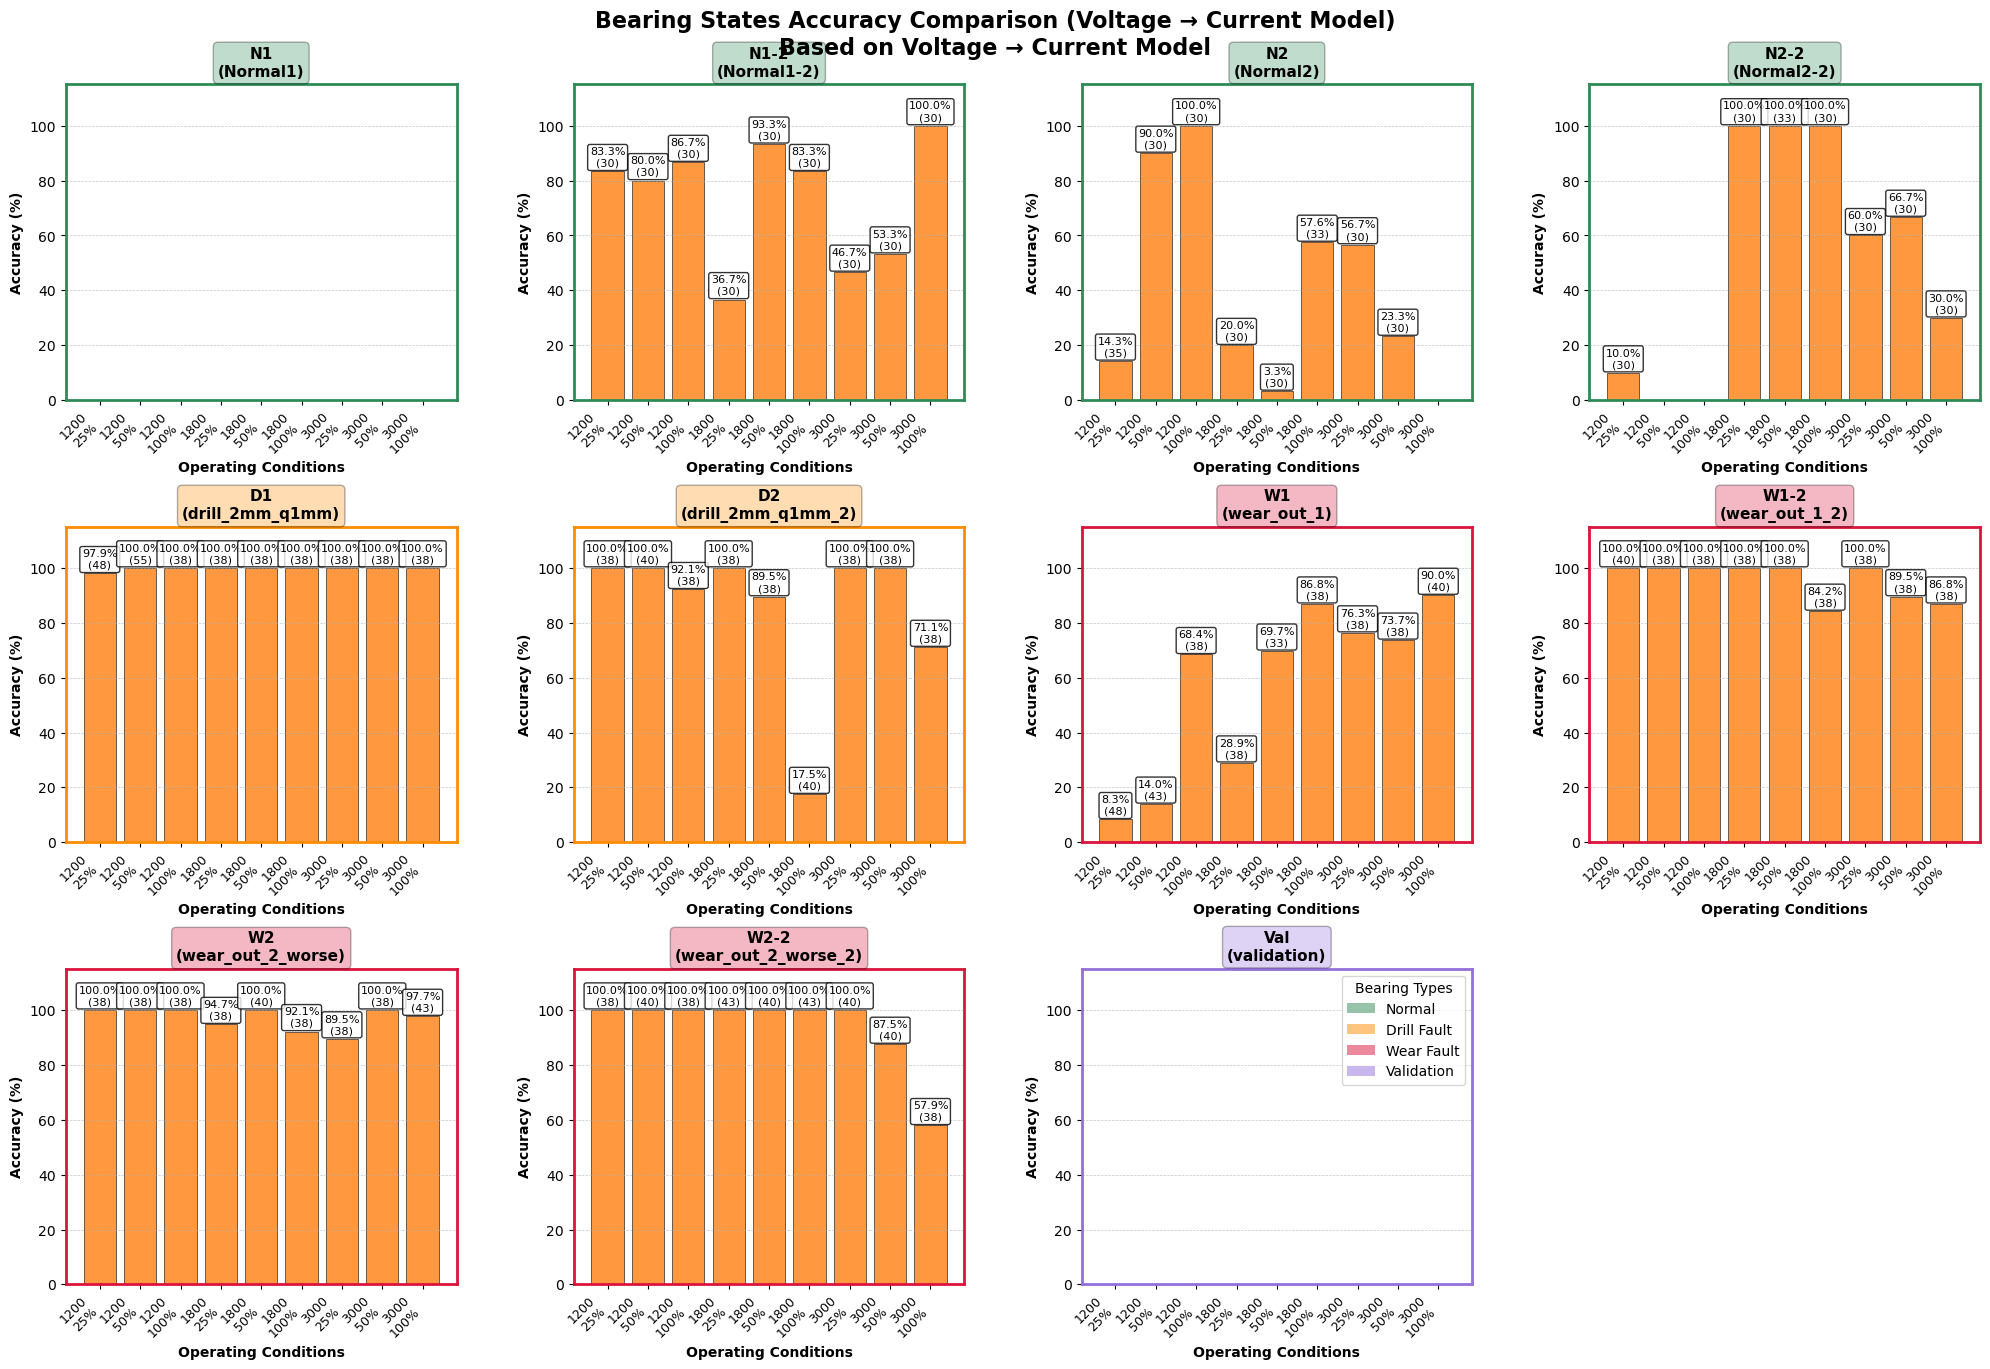

✅ 基於 Voltage → Current Model 的軸承狀態準確率比較圖完成

📈 圖表說明:
- 資料來源: operating_condition_results_VI
- 模型類型: Voltage → Current Model


🎉 所有可用資料集的軸承狀態準確率比較圖生成完成!

📊 成功生成了 1 個圖表:
  ✅ Voltage → Current Model (顏色: #ff7f0e)

💾 所有提取的準確率資料已存儲在 all_accuracy_results 變數中


In [13]:
# ===== 套用畫圖函數到四個資料集 =====

# 定義各模型的顏色和配置
model_configs = [
    # {
    #     'data': operating_condition_results_II,
    #     'name': 'operating_condition_results_II',
    #     'display_name': 'Current → Current Model',
    #     'color': '#1f77b4',  # 藍色
    #     'description': '電流輸入 → 電流輸出模型'
    # },
    {
        'data': operating_condition_results_VI,
        'name': 'operating_condition_results_VI',
        'display_name': 'Voltage → Current Model', 
        'color': '#ff7f0e',  # 橙色
        'description': '反電動勢輸入 → 電流輸出模型'
    },
    # {
    #     'data': operating_condition_results_VI_res,
    #     'name': 'operating_condition_results_VI_res',
    #     'display_name': 'Voltage → Current + Residual Model',
    #     'color': '#2ca02c',  # 綠色
    #     'description': '反電動勢輸入 → 電流輸出 + 殘差學習模型'
    # },
    # {
    #     'data': operating_condition_results_VI_res_cond,
    #     'name': 'operating_condition_results_VI_res_cond',
    #     'display_name': 'Voltage → Current + Residual + Conditional Model',
    #     'color': '#d62728',  # 紅色
    #     'description': '反電動勢輸入 → 電流輸出 + 殘差學習 + 條件式模型'
    # }
]

print("🎨 開始為四個資料集生成軸承狀態準確率比較圖...\n")

# 存儲所有提取的準確率資料
all_accuracy_results = {}

# 為每個資料集生成圖表
for i, config in enumerate(model_configs, 1):
    print(f"{'='*60}")
    print(f"📊 第 {i}/4 個圖表: {config['display_name']}")
    print(f"資料集: {config['name']}")
    print(f"描述: {config['description']}")
    print(f"{'='*60}")
    
    # 檢查資料是否存在
    if config['data'] is None or len(config['data']) == 0:
        print(f"❌ 警告: {config['name']} 資料為空或不存在")
        print(f"跳過此資料集...\n")
        continue
    
    # 使用通用函數生成圖表
    try:
        accuracy_data = create_bearing_accuracy_comparison(
            operating_results=config['data'],
            dataset_name=config['display_name'],
            model_color=config['color'],
            suptitle_prefix="Bearing States Accuracy Comparison"
        )
        
        # 存儲結果
        all_accuracy_results[config['name']] = {
            'accuracy_data': accuracy_data,
            'config': config
        }
        
        print(f"\n📈 圖表說明:")
        print(f"- 資料來源: {config['name']}")
        print(f"- 模型類型: {config['display_name']}")
        # print(f"- 佈局: 3×4 子圖陣列，每個子圖代表一個軸承狀態")
        # print(f"- X軸: 9種運轉條件 (3轉速 × 3負載)")
        # print(f"- Y軸: 準確率百分比")
        # print(f"- 柱狀圖顏色: {config['color']} ({config['display_name']})")
        # print(f"- 邊框顏色: 區分軸承狀態類型")
        # print(f"  🟢 綠色邊框: 正常狀態")
        # print(f"  🟠 橙色邊框: 鑽孔故障")
        # print(f"  🔴 紅色邊框: 磨耗故障")  
        # print(f"  🟣 紫色邊框: 驗證狀態")
        # print(f"- 柱頂標籤: 準確率百分比和樣本數量")
        print(f"\n")
        
    except Exception as e:
        print(f"❌ 生成 {config['name']} 圖表時發生錯誤: {str(e)}")
        print(f"跳過此資料集...\n")
        continue

print("🎉 所有可用資料集的軸承狀態準確率比較圖生成完成!")
print(f"\n📊 成功生成了 {len(all_accuracy_results)} 個圖表:")
for name, result in all_accuracy_results.items():
    display_name = result['config']['display_name']
    color = result['config']['color']
    print(f"  ✅ {display_name} (顏色: {color})")

print(f"\n💾 所有提取的準確率資料已存儲在 all_accuracy_results 變數中")

In [ ]:
# ===== 四個模型的綜合比較和總結 =====

def create_model_comparison_summary(all_results):
    """
    創建四個模型的準確率比較總結表
    """
    if not all_results:
        print("❌ 沒有可用的結果資料進行比較")
        return
    
    print("\n" + "="*80)
    print("📊 四個模型軸承狀態準確率綜合比較總結")
    print("="*80)
    
    # 獲取所有可用的軸承狀態和運轉條件
    all_bearing_states = set()
    all_op_conditions = set()
    
    for result_name, result_data in all_results.items():
        accuracy_data = result_data['accuracy_data']
        for op_cond, bearing_data in accuracy_data.items():
            all_op_conditions.add(op_cond)
            for bearing_state in bearing_data.keys():
                all_bearing_states.add(bearing_state)
    
    all_bearing_states = sorted(list(all_bearing_states))
    all_op_conditions = sorted(list(all_op_conditions))
    
    print(f"\n📋 比較範圍:")
    print(f"  • 模型數量: {len(all_results)} 個")
    print(f"  • 軸承狀態: {len(all_bearing_states)} 種")
    print(f"  • 運轉條件: {len(all_op_conditions)} 種")
    
    # 為每個軸承狀態創建比較表
    print(f"\n📈 各軸承狀態下四個模型的平均準確率:")
    print("-" * 80)
    
    bearing_labels = {
        'Normal1': 'N1', 'Normal1-2': 'N1-2', 'Normal2': 'N2', 'Normal2-2': 'N2-2',
        'drill_2mm_q1mm': 'D1', 'drill_2mm_q1mm_2': 'D2', 
        'wear_out_1': 'W1', 'wear_out_1_2': 'W1-2',
        'wear_out_2_worse': 'W2', 'wear_out_2_worse_2': 'W2-2',
        'validation': 'Val'
    }
    
    # 表格標題
    header = f"{'軸承狀態':<15}"
    model_names = []
    for result_name, result_data in all_results.items():
        model_display = result_data['config']['display_name']
        short_name = model_display.split()[0] + "→" + model_display.split()[2] if "→" in model_display else model_display[:12]
        model_names.append(short_name)
        header += f"{short_name:<18}"
    print(header)
    print("-" * 80)
    
    # 為每個軸承狀態計算平均準確率
    for bearing_state in all_bearing_states:
        if bearing_state not in bearing_labels:
            continue
            
        row = f"{bearing_labels[bearing_state]:<15}"
        
        for result_name, result_data in all_results.items():
            accuracy_data = result_data['accuracy_data']
            
            # 收集該軸承狀態在所有運轉條件下的準確率
            accuracies = []
            for op_cond in all_op_conditions:
                if (op_cond in accuracy_data and 
                    bearing_state in accuracy_data[op_cond]):
                    acc = accuracy_data[op_cond][bearing_state].get('accuracy', 0)
                    if acc > 0:
                        accuracies.append(acc)
            
            # 計算平均準確率
            if accuracies:
                avg_accuracy = np.mean(accuracies)
                row += f"{avg_accuracy:>6.1f}% ({len(accuracies):>2d})<6"
            else:
                row += f"{'N/A':<18}"
        
        print(row)
    
    print("-" * 80)
    print("註：括號內數字為有效資料點數量")
    
    # 創建運轉條件比較
    print(f"\n📈 各運轉條件下四個模型的平均準確率:")
    print("-" * 80)
    
    operating_condition_mapping = {
        '1200 0.5v': '1200@25%', '1200 1.0v': '1200@50%', '1200 2.0v': '1200@100%',
        '1800 0.5v': '1800@25%', '1800 1.0v': '1800@50%', '1800 2.0v': '1800@100%',
        '3000 0.5v': '3000@25%', '3000 1.0v': '3000@50%', '3000 2.0v': '3000@100%'
    }
    
    # 表格標題
    header = f"{'運轉條件':<12}"
    for short_name in model_names:
        header += f"{short_name:<18}"
    print(header)
    print("-" * 80)
    
    # 為每個運轉條件計算平均準確率
    for op_cond in all_op_conditions:
        display_cond = operating_condition_mapping.get(op_cond, op_cond)
        row = f"{display_cond:<12}"
        
        for result_name, result_data in all_results.items():
            accuracy_data = result_data['accuracy_data']
            
            # 收集該運轉條件下所有軸承狀態的準確率
            accuracies = []
            if op_cond in accuracy_data:
                for bearing_state, stats in accuracy_data[op_cond].items():
                    if bearing_state in bearing_labels:
                        acc = stats.get('accuracy', 0)
                        if acc > 0:
                            accuracies.append(acc)
            
            # 計算平均準確率
            if accuracies:
                avg_accuracy = np.mean(accuracies)
                row += f"{avg_accuracy:>6.1f}% ({len(accuracies):>2d})<6"
            else:
                row += f"{'N/A':<18}"
        
        print(row)
    
    print("-" * 80)
    print("註：括號內數字為有效資料點數量")
    
    # 計算總體統計
    print(f"\n📊 四個模型總體統計:")
    print("-" * 50)
    
    for result_name, result_data in all_results.items():
        config = result_data['config']
        accuracy_data = result_data['accuracy_data']
        
        # 收集所有準確率
        all_accuracies = []
        total_samples = 0
        
        for op_cond, bearing_data in accuracy_data.items():
            for bearing_state, stats in bearing_data.items():
                if bearing_state in bearing_labels:
                    acc = stats.get('accuracy', 0)
                    samples = stats.get('total_samples', 0)
                    if acc > 0:
                        all_accuracies.append(acc)
                        total_samples += samples
        
        if all_accuracies:
            print(f"\n🔹 {config['display_name']}:")
            print(f"   平均準確率: {np.mean(all_accuracies):.1f}%")
            print(f"   準確率範圍: {np.min(all_accuracies):.1f}% - {np.max(all_accuracies):.1f}%")
            print(f"   標準差: {np.std(all_accuracies):.1f}%")
            print(f"   有效資料點: {len(all_accuracies)} 個")
            print(f"   總樣本數: {total_samples} 個")
        else:
            print(f"\n🔹 {config['display_name']}: 無有效資料")

# 執行綜合比較
if 'all_accuracy_results' in locals() and all_accuracy_results:
    create_model_comparison_summary(all_accuracy_results)
else:
    print("❌ 沒有找到 all_accuracy_results 資料，請先執行上面的畫圖代碼")


📊 四個模型軸承狀態準確率綜合比較總結

📋 比較範圍:
  • 模型數量: 4 個
  • 軸承狀態: 9 種
  • 運轉條件: 9 種

📈 各軸承狀態下四個模型的平均準確率:
--------------------------------------------------------------------------------
軸承狀態           Current→Current   Voltage→Current   Voltage→Current   Voltage→Current   
--------------------------------------------------------------------------------
N1-2             25.8% ( 8)<6  84.4% ( 9)<6  82.6% ( 9)<6  75.6% ( 9)<6
N2               40.1% ( 5)<6  55.0% ( 8)<6  58.2% ( 8)<6  42.9% ( 8)<6
N2-2             33.3% ( 6)<6  57.0% ( 9)<6  56.3% ( 9)<6  62.1% ( 8)<6
D1               41.8% ( 9)<6 100.0% ( 9)<6  99.1% ( 9)<6  99.7% ( 9)<6
D2               38.3% ( 6)<6  92.4% ( 9)<6  90.7% ( 9)<6  87.8% ( 9)<6
W1               40.4% ( 6)<6  69.8% ( 9)<6  69.8% ( 9)<6  62.0% ( 9)<6
W1-2             20.0% ( 8)<6  96.5% ( 9)<6  89.5% ( 9)<6  88.9% ( 9)<6
W2               39.0% ( 9)<6  99.1% ( 9)<6  93.3% ( 9)<6  95.2% ( 9)<6
W2-2             43.8% ( 7)<6  98.0% ( 9)<6  95.1% ( 9)<6  96.5% ( 9)<6
---------

## 🎯 使用說明和總結

### 📋 已建立的功能：

1. **通用畫圖函數** `create_bearing_accuracy_comparison()`
   - 適用於任何 `operating_condition_results` 格式的資料集
   - 自動提取準確率資料並生成 3×4 軸承狀態比較圖
   - 支援自訂模型顏色和標題

2. **四個資料集自動化處理**：
   - `operating_condition_results_II` (電流→電流模型) - 藍色
   - `operating_condition_results_VI` (反電動勢→電流模型) - 橙色  
   - `operating_condition_results_VI_res` (反電動勢→電流+殘差模型) - 綠色
   - `operating_condition_results_VI_res_cond` (反電動勢→電流+殘差+條件式模型) - 紅色

3. **綜合比較分析**：
   - 各軸承狀態下四個模型的平均準確率比較
   - 各運轉條件下四個模型的平均準確率比較
   - 總體統計數據包含平均值、範圍、標準差等

### 🚀 執行順序：

1. 先執行通用函數定義 cell
2. 再執行四個資料集套用 cell（會自動生成 4 張圖表）
3. 最後執行綜合比較分析 cell（產生詳細統計表格）

### 📊 輸出內容：

- **4張軸承狀態準確率比較圖**：每張圖包含 11 個軸承狀態子圖
- **資料結構檢查報告**：顯示每個資料集的可用運轉條件和軸承工況
- **綜合比較表格**：軸承狀態和運轉條件的交叉比較
- **統計總結**：四個模型的整體表現分析

### 💾 變數存儲：

- `all_accuracy_results`：包含所有四個模型的提取準確率資料
- `create_bearing_accuracy_comparison()`：可重複使用的通用畫圖函數